# CIFAR 10 challenge

## Problem
Build models for photo classification. Use validation set to tune the model, and test the best model we can get with test set.

## Data
https://www.cs.toronto.edu/~kriz/cifar.html
The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

In this report, I directly loaded the dataset from keras API.

## The decisions I made
1. Develop a CNN From Scratch and tune the structure and some of the hyperparameters throught experiment results

2. tune only one parameter at one time, and use the one which gets best validation result in the following experiments

3. In this report, I didn't set early stop as I wanna see the accuracy and loss changes even when the model is overfitting

## Experiment settings
**1. What library you work with?**

Keras. I choose Keras because Keras is a high level API built on TensorFlow, which is user-friendly to build both simple or complex deep learning networks. It gives me enough flexibility to tune the model so it would be a good choise between flexibility and easy to code with.

**2. State the net architecture you chose.**

In the experiments, I start with a simple two blocks CNN. From the reference `VERY DEEP CONVOLUTIONAL NETWORKS FOR LARGE-SCALE IMAGE RECOGNITION` (https://arxiv.org/pdf/1409.1556.pdf), we can learn that an useful block is in [CONV] — [CONV] - [MAXP] structure. And it would be what we will use in this report.

**3. State your regularization and optimization techniques.**

For regularization, I used weight decay and dropout. And I also tried adding batch normalization to the model, which also have slightly regularization effect.

For optimization, I tried using different optimizers(sgd with momentum, RMSprop, adam), tested the effect of increasing number of blocks of CNN, and added Batch Normalization and Data Augmentation.


## Experiment environment
* Google cloud
* GPU: Tesla-K70

## Experiments

For the experiments result, I add the main experiment result graphs here for a quick review. Please see the details and analysis in the main article.

### Section 1. Regularization

#### 1. weight decay

![weightDecay.png](graphs/weightDecay.png)

#### 2. dropout + weight decay

![dropout+wd.png](graphs/dropout+wd.png)

#### 3. find the best dropout rate

![dropoutRate.png](graphs/dropoutRate.png)

### Section 2. Network structure

#### Number of blocks of the network

![numOfBlocks.png](graphs/numOfBlocks.png)

### Section 3. Optimizers

![optimizers.png](graphs/optimizers.png)

### Section 4.  Batch normalization

### Section 5. Data Augmentation

![bn+da.png](graphs/bn+da.png)


## Test result
I added the test result graphs here for a quick review. Please see the details and analysis at the end of this report.

![matrix.png](graphs/matrix.png)

![heat.png](graphs/heat.png)


First, we need to import the pakages will be used in this report.

In [1]:
# Import packages
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import print_summary, to_categorical
from keras.optimizers import SGD, RMSprop
from keras.regularizers import l2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os

Using TensorFlow backend.


Initialize the model parameters. Here I choose the very commonly used settings for the baseline.

In [2]:
batch_size = 32
num_classes = 10
epochs = 100
save_dir = os.path.join(os.getcwd(), 'saved_models')

Load the CIFAR10 data from Keras dataset.

In [3]:
# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# split the training data into train set and validation set:
x_train,x_validation,y_train,y_validation = train_test_split(x_train,y_train,test_size=0.2)
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_validation.shape[0], 'validation samples')
print(x_test.shape[0], 'test samples')

# see the sample value of image features:
print(x_train[0][0])

# see the label format:
print(y_train[0])

x_train shape: (40000, 32, 32, 3)
40000 train samples
10000 validation samples
10000 test samples
[[105 115  75]
 [116 108  80]
 [138 114  85]
 [138 117  78]
 [107  98  58]
 [ 97  97  57]
 [ 92  91  43]
 [116 116  59]
 [127 130  74]
 [132 119  68]
 [137 126  74]
 [127 136  78]
 [ 98 139  71]
 [ 77 126  56]
 [ 90 136  67]
 [108 153  84]
 [ 97 147  73]
 [116 137  72]
 [114 117  60]
 [107 117  61]
 [106 114  62]
 [102 134  78]
 [ 80 141  72]
 [ 85 145  74]
 [ 58 132  53]
 [ 63 146  62]
 [ 78 161  76]
 [ 72 155  71]
 [ 79 162  78]
 [ 91 174  86]
 [ 93 174  85]
 [ 93 175  85]]
[4]


From the above result, we can see that there are 40,000 examples in the training dataset, 10,000 examples in the validation dataset and 10,000 in the test dataset and that images are indeed square with 32×32 pixels and color, with three channels. We can also confirm that the feature value range is from 0-255, and the label is the value from 0-9. We will do some preprocessing of the raw data later. Before that, let's take a look at the sample images.

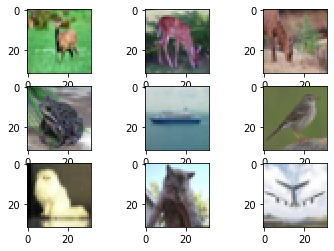

In [4]:
# plot first few images
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # plot raw pixel data
    plt.imshow(x_train[i])
# show the figure
plt.show()

From the above plotted images, we can tell that the dataset contains images with mostly centered objects, which means we don't need to do too much extra parsing for the raw data. Now, we need to convert the labels in the dataset into categorical matrix structure so that it can be used when training the model.

In [5]:
# Convert class vectors to binary class matrices.
y_train = to_categorical(y_train, num_classes)
y_validation = to_categorical(y_validation, num_classes)
y_test = to_categorical(y_test, num_classes)
print(y_train[0])

[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


First step of the preprocessing is to normalize the pixel values, e.g. rescale them to the range [0,1]. This involves first converting the data type from unsigned integers to floats, then dividing the pixel values by the maximum value(255).

In [6]:
# Convert the integers to floats
x_train = x_train.astype('float32')
x_validation = x_validation.astype('float32')
x_test = x_test.astype('float32')

# Normalize the data
x_train /= 255
x_validation /= 255
x_test /= 255

# See the sample feature values after normalization
print(x_train[0][0])

[[0.4117647  0.4509804  0.29411766]
 [0.45490196 0.42352942 0.3137255 ]
 [0.5411765  0.44705883 0.33333334]
 [0.5411765  0.45882353 0.30588236]
 [0.41960785 0.38431373 0.22745098]
 [0.38039216 0.38039216 0.22352941]
 [0.36078432 0.35686275 0.16862746]
 [0.45490196 0.45490196 0.23137255]
 [0.49803922 0.50980395 0.2901961 ]
 [0.5176471  0.46666667 0.26666668]
 [0.5372549  0.49411765 0.2901961 ]
 [0.49803922 0.53333336 0.30588236]
 [0.38431373 0.54509807 0.2784314 ]
 [0.3019608  0.49411765 0.21960784]
 [0.3529412  0.53333336 0.2627451 ]
 [0.42352942 0.6        0.32941177]
 [0.38039216 0.5764706  0.28627452]
 [0.45490196 0.5372549  0.28235295]
 [0.44705883 0.45882353 0.23529412]
 [0.41960785 0.45882353 0.23921569]
 [0.41568628 0.44705883 0.24313726]
 [0.4        0.5254902  0.30588236]
 [0.3137255  0.5529412  0.28235295]
 [0.33333334 0.5686275  0.2901961 ]
 [0.22745098 0.5176471  0.20784314]
 [0.24705882 0.57254905 0.24313726]
 [0.30588236 0.6313726  0.29803923]
 [0.28235295 0.60784316 0.27

Use a common neural network model architecture in the literature: [CONV] - [CONV] - [MAXP] -[CONV] - [CONV] - [MAXP] - [Dense]. To avoid long training time at the starting point, we only use two blocks of [CONV] - [CONV] - [MAXP] as our baseline.

In [7]:
def build_model(dropout = False, l2_decay_rate = 0.0):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same',
                     input_shape=x_train.shape[1:], kernel_regularizer=l2(l2_decay_rate)))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3), padding='same', kernel_regularizer=l2(l2_decay_rate)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    if dropout: 
        model.add(Dropout(0.2))

    model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(l2_decay_rate)))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(l2_decay_rate)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    if dropout: 
        model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(128, kernel_regularizer=l2(l2_decay_rate)))
    model.add(Activation('relu'))
    if dropout: 
        model.add(Dropout(0.4))
    model.add(Dense(num_classes, kernel_regularizer=l2(l2_decay_rate)))
    model.add(Activation('softmax'))
    
    return model

This method is to save models to directory. In case the connection with cloud is interrupted, we can still use the trained models later.

In [8]:
def save_model(model, model_name):
    # Save model and weights
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    model_path = os.path.join(save_dir, model_name)
    model.save(model_path)
    print('Saved trained model as %s ' % (model_path + model_name))

This method is to train the model, it contains:
    1. initiate optimizer
    2. compile the model
    3. train the data and get training history
    4. save the trained model

For the optimizer, I used SGD with momentum here. (https://www.coursera.org/learn/deep-neural-network/lecture/y0m1f/gradient-descent-with-momentum) momentum is method which helps accelerate gradients vectors in the right directions, thus leading to faster converging.

In [9]:
# Train the model
def train_model(model_name, dropout = False, weight_decay = 0.0):
    # As the model receives the weight decay as l2 decay rate, we need to 
    # divide the weight decay rate by 2 here.
    model = build_model(dropout, weight_decay/2)
    
    # initiate optimizers
    opt = SGD(lr=0.001, momentum=0.9, decay=1e-6, nesterov=False)

    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

    train_history = model.fit(x_train, 
                              y_train,
                              batch_size=batch_size,
                              epochs=epochs,
                              validation_data=(x_validation, y_validation))

    save_model(model = model, model_name = model_name)
    
    return train_history,model

In [10]:
# Plot the accuracy and loss using model history
def plot_model(history, modelname):
    plt.figure(figsize=(12,6))
    # summarize history for accuracy
    plt.subplot(121)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(modelname+' Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    # summarize history for loss
    plt.subplot(122)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(modelname+' Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()
    return None

In [11]:
# Evaluate the model on the validation set
def evaluate_model(model):
    # Score trained model.
    scores = model.evaluate(x_validation, y_validation, verbose=1)
    print('Validation loss:', scores[0])
    print('Validation accuracy:', scores[1])

## Section 1. Regularization
### 1. weight decay
#### (1) no weight decay

In [12]:
history_dFalse_wd0, model_dFalse_wd0 = train_model("model_dFalse_wd0.h5", False, 0.0)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 14s 344us/step - loss: 1.9848 - accuracy: 0.2801 - val_loss: 1.6991 - val_accuracy: 0.3996
Epoch 2/100
40000/40000 [==============================] - 12s 307us/step - loss: 1.5901 - accuracy: 0.4305 - val_loss: 1.4818 - val_accuracy: 0.4658
Epoch 3/100
40000/40000 [==============================] - 13s 315us/step - loss: 1.3940 - accuracy: 0.4993 - val_loss: 1.3435 - val_accuracy: 0.5166
Epoch 4/100
40000/40000 [==============================] - 12s 307us/step - loss: 1.2732 - accuracy: 0.5456 - val_loss: 1.2512 - val_accuracy: 0.5572
Epoch 5/100
40000/40000 [==============================] - 12s 307us/step - loss: 1.1671 - accuracy: 0.5834 - val_loss: 1.1614 - val_accuracy: 0.5898
Epoch 6/100
40000/40000 [==============================] - 12s 307us/step - loss: 1.0725 - accuracy: 0.6215 - val_los

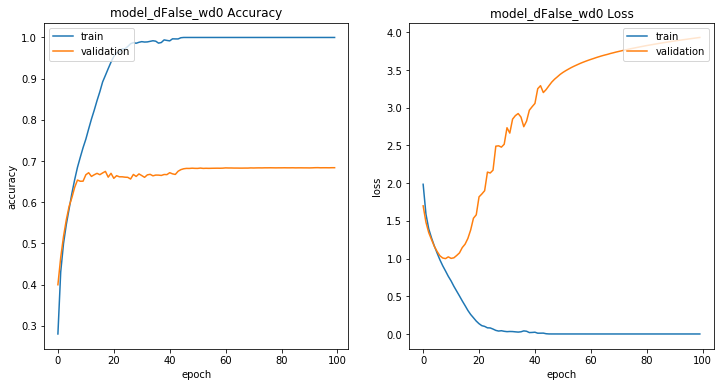

10000/10000 [==============================] - 1s 129us/step
Validation loss: 3.9315530930042266
Validation accuracy: 0.6837999820709229


In [13]:
plot_model(history_dFalse_wd0, "model_dFalse_wd0")
evaluate_model(model_dFalse_wd0)

From the graph above, we can see that when there is no regularization techniques used, the model started getting overfit on epoch 13.

#### (2) weight decay = 0.00005
Let's now try a small weight decay to see whether it helps.

In [14]:
history_dFalse_wd000005, model_dFalse_wd000005 = train_model("model_dFalse_wd000005.h5", False, 0.00005)

Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 13s 329us/step - loss: 2.0295 - accuracy: 0.2697 - val_loss: 1.7834 - val_accuracy: 0.3696
Epoch 2/100
40000/40000 [==============================] - 13s 329us/step - loss: 1.6195 - accuracy: 0.4243 - val_loss: 1.5145 - val_accuracy: 0.4583
Epoch 3/100
40000/40000 [==============================] - 13s 322us/step - loss: 1.4325 - accuracy: 0.4904 - val_loss: 1.3694 - val_accuracy: 0.5095
Epoch 4/100
40000/40000 [==============================] - 13s 321us/step - loss: 1.2862 - accuracy: 0.5434 - val_loss: 1.2300 - val_accuracy: 0.5656
Epoch 5/100
40000/40000 [==============================] - 13s 322us/step - loss: 1.1594 - accuracy: 0.5927 - val_loss: 1.2376 - val_accuracy: 0.5702
Epoch 6/100
40000/40000 [==============================] - 13s 321us/step - loss: 1.0589 - accuracy: 0.6296 - val_loss: 1.0777 - val_accuracy: 0.6223
Epoch 7/100
40000/40000 [=========================

Epoch 55/100
40000/40000 [==============================] - 13s 322us/step - loss: 0.0178 - accuracy: 1.0000 - val_loss: 3.0610 - val_accuracy: 0.6920
Epoch 56/100
40000/40000 [==============================] - 13s 321us/step - loss: 0.0177 - accuracy: 1.0000 - val_loss: 3.0649 - val_accuracy: 0.6925
Epoch 57/100
40000/40000 [==============================] - 13s 321us/step - loss: 0.0177 - accuracy: 1.0000 - val_loss: 3.0690 - val_accuracy: 0.6922
Epoch 58/100
40000/40000 [==============================] - 13s 321us/step - loss: 0.0177 - accuracy: 1.0000 - val_loss: 3.0715 - val_accuracy: 0.6921
Epoch 59/100
40000/40000 [==============================] - 13s 321us/step - loss: 0.0177 - accuracy: 1.0000 - val_loss: 3.0741 - val_accuracy: 0.6922
Epoch 60/100
40000/40000 [==============================] - 13s 321us/step - loss: 0.0177 - accuracy: 1.0000 - val_loss: 3.0768 - val_accuracy: 0.6925
Epoch 61/100
40000/40000 [==============================] - 13s 321us/step - loss: 0.0177 - ac

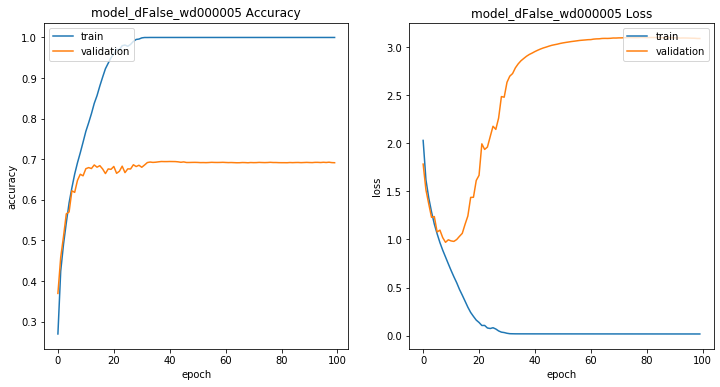

10000/10000 [==============================] - 1s 141us/step
Validation loss: 3.089249923610687
Validation accuracy: 0.6915000081062317


In [15]:
plot_model(history_dFalse_wd000005, "model_dFalse_wd000005")
evaluate_model(model_dFalse_wd000005)

From the above graph, we can tell the weight decay didn't help a lot. Let's increase the weight decay rate to make one more try:

#### (3) weight decay = 0.0005

In [16]:
history_dFalse_wd00005, model_dFalse_wd00005 = train_model("model_dFalse_wd00005.h5", False, 0.0005)

Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 13s 332us/step - loss: 2.0952 - accuracy: 0.2783 - val_loss: 1.8216 - val_accuracy: 0.3844
Epoch 2/100
40000/40000 [==============================] - 13s 324us/step - loss: 1.6969 - accuracy: 0.4275 - val_loss: 1.5665 - val_accuracy: 0.4777
Epoch 3/100
40000/40000 [==============================] - 13s 324us/step - loss: 1.4984 - accuracy: 0.4997 - val_loss: 1.4422 - val_accuracy: 0.5164
Epoch 4/100
40000/40000 [==============================] - 13s 324us/step - loss: 1.3742 - accuracy: 0.5477 - val_loss: 1.3894 - val_accuracy: 0.5409
Epoch 5/100
40000/40000 [==============================] - 13s 324us/step - loss: 1.2750 - accuracy: 0.5868 - val_loss: 1.3058 - val_accuracy: 0.5725
Epoch 6/100
40000/40000 [==============================] - 13s 324us/step - loss: 1.1923 - accuracy: 0.6179 - val_loss: 1.2803 - val_accuracy: 0.5787
Epoch 7/100
40000/40000 [=========================

Epoch 55/100
40000/40000 [==============================] - 13s 325us/step - loss: 0.1147 - accuracy: 1.0000 - val_loss: 2.3212 - val_accuracy: 0.6803
Epoch 56/100
40000/40000 [==============================] - 13s 324us/step - loss: 0.1137 - accuracy: 1.0000 - val_loss: 2.3147 - val_accuracy: 0.6807
Epoch 57/100
40000/40000 [==============================] - 13s 324us/step - loss: 0.1128 - accuracy: 1.0000 - val_loss: 2.3133 - val_accuracy: 0.6799
Epoch 58/100
40000/40000 [==============================] - 13s 324us/step - loss: 0.1119 - accuracy: 1.0000 - val_loss: 2.3116 - val_accuracy: 0.6806
Epoch 59/100
40000/40000 [==============================] - 13s 324us/step - loss: 0.1110 - accuracy: 1.0000 - val_loss: 2.3026 - val_accuracy: 0.6784
Epoch 60/100
40000/40000 [==============================] - 13s 331us/step - loss: 0.1101 - accuracy: 1.0000 - val_loss: 2.2989 - val_accuracy: 0.6809
Epoch 61/100
40000/40000 [==============================] - 13s 332us/step - loss: 0.1092 - ac

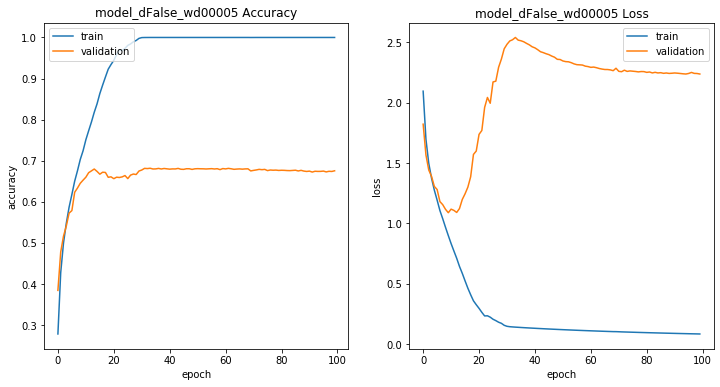

10000/10000 [==============================] - 1s 142us/step
Validation loss: 2.2372286745071412
Validation accuracy: 0.6754999756813049


In [17]:
plot_model(history_dFalse_wd00005, "model_dFalse_wd00005")
evaluate_model(model_dFalse_wd00005)

#### (4) weight decay = 0.005

In [18]:
history_dFalse_wd0005, model_dFalse_wd0005 = train_model("model_dFalse_wd0005.h5", False, 0.005)

Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 13s 333us/step - loss: 2.9428 - accuracy: 0.2885 - val_loss: 2.6394 - val_accuracy: 0.3813
Epoch 2/100
40000/40000 [==============================] - 13s 323us/step - loss: 2.4370 - accuracy: 0.4459 - val_loss: 2.2901 - val_accuracy: 0.4848
Epoch 3/100
40000/40000 [==============================] - 13s 324us/step - loss: 2.1932 - accuracy: 0.5049 - val_loss: 2.1289 - val_accuracy: 0.5150
Epoch 4/100
40000/40000 [==============================] - 13s 325us/step - loss: 2.0248 - accuracy: 0.5422 - val_loss: 1.9729 - val_accuracy: 0.5453
Epoch 5/100
40000/40000 [==============================] - 13s 326us/step - loss: 1.8757 - accuracy: 0.5713 - val_loss: 1.8811 - val_accuracy: 0.5650
Epoch 6/100
40000/40000 [==============================] - 13s 326us/step - loss: 1.7489 - accuracy: 0.6013 - val_loss: 1.7914 - val_accuracy: 0.5759
Epoch 7/100
40000/40000 [=========================

Epoch 55/100
40000/40000 [==============================] - 13s 329us/step - loss: 0.5164 - accuracy: 0.9760 - val_loss: 1.9271 - val_accuracy: 0.6470
Epoch 56/100
40000/40000 [==============================] - 13s 335us/step - loss: 0.5221 - accuracy: 0.9735 - val_loss: 1.9827 - val_accuracy: 0.6349
Epoch 57/100
40000/40000 [==============================] - 13s 325us/step - loss: 0.5244 - accuracy: 0.9731 - val_loss: 1.9877 - val_accuracy: 0.6369
Epoch 58/100
40000/40000 [==============================] - 13s 325us/step - loss: 0.5152 - accuracy: 0.9763 - val_loss: 1.9687 - val_accuracy: 0.6331
Epoch 59/100
40000/40000 [==============================] - 13s 325us/step - loss: 0.5083 - accuracy: 0.9791 - val_loss: 1.9738 - val_accuracy: 0.6483
Epoch 60/100
40000/40000 [==============================] - 13s 326us/step - loss: 0.5130 - accuracy: 0.9772 - val_loss: 1.9195 - val_accuracy: 0.6479
Epoch 61/100
40000/40000 [==============================] - 13s 333us/step - loss: 0.5040 - ac

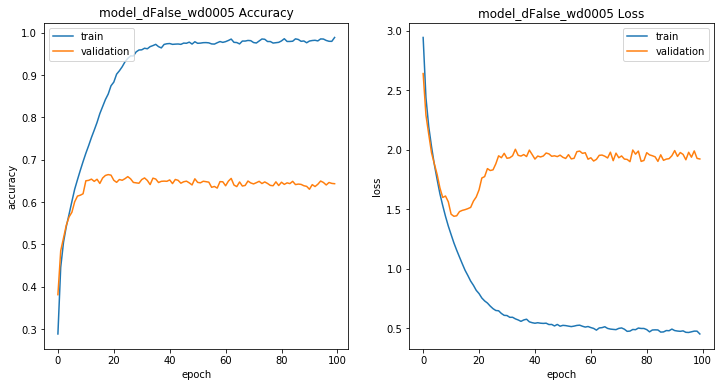

10000/10000 [==============================] - 1s 145us/step
Validation loss: 1.9213611028671265
Validation accuracy: 0.6434000134468079


In [19]:
plot_model(history_dFalse_wd0005, "model_dFalse_wd0005")
evaluate_model(model_dFalse_wd0005)

#### (5) weight decay = 0.05

In [20]:
history_dFalse_wd005, model_dFalse_wd005 = train_model("model_dFalse_wd005.h5", False, 0.05)

Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 13s 332us/step - loss: 8.0852 - accuracy: 0.2186 - val_loss: 5.0577 - val_accuracy: 0.2669
Epoch 2/100
40000/40000 [==============================] - 13s 322us/step - loss: 3.7120 - accuracy: 0.3270 - val_loss: 2.8260 - val_accuracy: 0.3568
Epoch 3/100
40000/40000 [==============================] - 14s 338us/step - loss: 2.4760 - accuracy: 0.3629 - val_loss: 2.2169 - val_accuracy: 0.3786
Epoch 4/100
40000/40000 [==============================] - 13s 323us/step - loss: 2.1049 - accuracy: 0.3860 - val_loss: 2.0045 - val_accuracy: 0.4000
Epoch 5/100
40000/40000 [==============================] - 13s 323us/step - loss: 1.9888 - accuracy: 0.4054 - val_loss: 1.9650 - val_accuracy: 0.3983
Epoch 6/100
40000/40000 [==============================] - 13s 323us/step - loss: 1.9479 - accuracy: 0.4121 - val_loss: 2.0047 - val_accuracy: 0.3804
Epoch 7/100
40000/40000 [=========================

Epoch 55/100
40000/40000 [==============================] - 13s 331us/step - loss: 1.8432 - accuracy: 0.4891 - val_loss: 1.8320 - val_accuracy: 0.4821
Epoch 56/100
40000/40000 [==============================] - 13s 323us/step - loss: 1.8460 - accuracy: 0.4877 - val_loss: 1.8706 - val_accuracy: 0.4733
Epoch 57/100
40000/40000 [==============================] - 13s 323us/step - loss: 1.8357 - accuracy: 0.4924 - val_loss: 1.8215 - val_accuracy: 0.4919
Epoch 58/100
40000/40000 [==============================] - 13s 323us/step - loss: 1.8377 - accuracy: 0.4929 - val_loss: 1.8354 - val_accuracy: 0.4901
Epoch 59/100
40000/40000 [==============================] - 13s 323us/step - loss: 1.8386 - accuracy: 0.4929 - val_loss: 1.8488 - val_accuracy: 0.4818
Epoch 60/100
40000/40000 [==============================] - 13s 323us/step - loss: 1.8374 - accuracy: 0.4934 - val_loss: 1.8284 - val_accuracy: 0.4888
Epoch 61/100
40000/40000 [==============================] - 13s 323us/step - loss: 1.8374 - ac

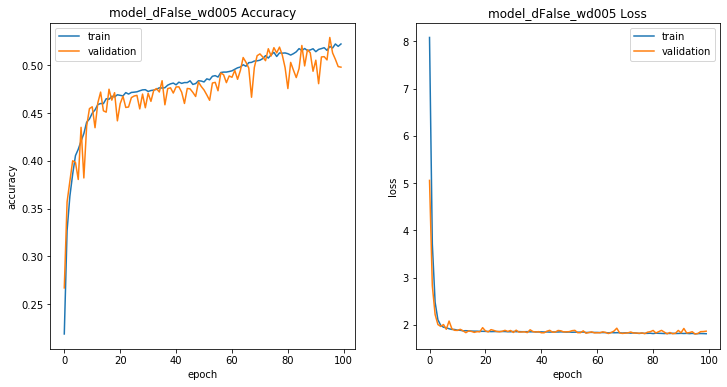

10000/10000 [==============================] - 1s 146us/step
Validation loss: 1.8642936628341675
Validation accuracy: 0.49799999594688416


In [21]:
plot_model(history_dFalse_wd005, "model_dFalse_wd005")
evaluate_model(model_dFalse_wd005)

The overfit decreases when we increase the weight decay rate! Let's plot the above graphs together to see the comparison:

In [46]:
def plot_all_models(history1, history2, history3, history4, history5, title, legend1, legend2, legend3, legend4, legend5):
    plt.figure(figsize=(12,6))
    # summarize history for accuracy
    plt.subplot(121)
    plt.plot(history1.history['val_accuracy'])
    plt.plot(history2.history['val_accuracy'])
    plt.plot(history3.history['val_accuracy'])
    plt.plot(history4.history['val_accuracy'])
    plt.plot(history5.history['val_accuracy'])
    plt.title(title + ' Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend([legend1, legend2, legend3, legend4, legend5], loc='lower right')
    # summarize history for loss
    plt.subplot(122)
    plt.plot(history1.history['val_loss'])
    plt.plot(history2.history['val_loss'])
    plt.plot(history3.history['val_loss'])
    plt.plot(history4.history['val_loss'])
    plt.plot(history5.history['val_loss'])

    plt.title(title+ ' Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend([legend1, legend2, legend3, legend4, legend5], loc='upper left')
    plt.show()
    return None

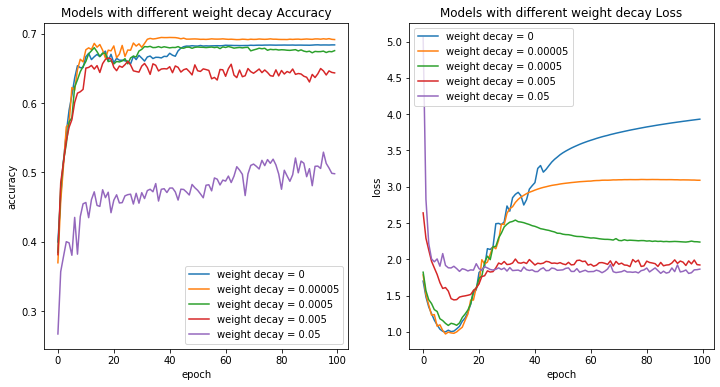

In [47]:
plot_all_models(history_dFalse_wd0, history_dFalse_wd000005, history_dFalse_wd00005, history_dFalse_wd0005, history_dFalse_wd005, 'Models with different weight decay', 'weight decay = 0', 'weight decay = 0.00005', 'weight decay = 0.0005', 'weight decay = 0.005', 'weight decay = 0.05')

I would say the weight decay works to prevent overfit, but it affect the model accuracy, which is not a good symptom. Let's try using some other regularization techniques.

### 2. dropout
The term “dropout” refers to dropping out units in a neural network. It can prevent overfitting because the outputs of a layer under dropout are randomly subsampled. It also has the effect of reducing the capacity or thinning the network during training.

Here I used an increasing dropout rate(0.2, 0.3, 0.4) as the baseline.

#### (1) dropout + no weight decay

In [22]:
history_dTrue_wd0, model_dTrue_wd0 = train_model("model_dTrue_wd0.h5", True, 0.0)

Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 14s 346us/step - loss: 2.1426 - accuracy: 0.2022 - val_loss: 1.9247 - val_accuracy: 0.3107
Epoch 2/100
40000/40000 [==============================] - 13s 333us/step - loss: 1.8521 - accuracy: 0.3303 - val_loss: 1.6423 - val_accuracy: 0.4137
Epoch 3/100
40000/40000 [==============================] - 13s 329us/step - loss: 1.6564 - accuracy: 0.3953 - val_loss: 1.5077 - val_accuracy: 0.4590
Epoch 4/100
40000/40000 [==============================] - 13s 330us/step - loss: 1.5230 - accuracy: 0.4496 - val_loss: 1.3926 - val_accuracy: 0.4935
Epoch 5/100
40000/40000 [==============================] - 13s 331us/step - loss: 1.4274 - accuracy: 0.4825 - val_loss: 1.2965 - val_accuracy: 0.5351
Epoch 6/100
40000/40000 [==============================] - 13s 329us/step - loss: 1.3557 - accuracy: 0.5138 - val_loss: 1.2232 - val_accuracy: 0.5619
Epoch 7/100
40000/40000 [=========================

Epoch 55/100
40000/40000 [==============================] - 13s 329us/step - loss: 0.4432 - accuracy: 0.8401 - val_loss: 0.6546 - val_accuracy: 0.7823
Epoch 56/100
40000/40000 [==============================] - 13s 329us/step - loss: 0.4387 - accuracy: 0.8406 - val_loss: 0.6573 - val_accuracy: 0.7847
Epoch 57/100
40000/40000 [==============================] - 13s 330us/step - loss: 0.4318 - accuracy: 0.8446 - val_loss: 0.6543 - val_accuracy: 0.7863
Epoch 58/100
40000/40000 [==============================] - 13s 329us/step - loss: 0.4273 - accuracy: 0.8450 - val_loss: 0.6439 - val_accuracy: 0.7841
Epoch 59/100
40000/40000 [==============================] - 13s 329us/step - loss: 0.4173 - accuracy: 0.8473 - val_loss: 0.6743 - val_accuracy: 0.7840
Epoch 60/100
40000/40000 [==============================] - 13s 330us/step - loss: 0.4052 - accuracy: 0.8535 - val_loss: 0.6495 - val_accuracy: 0.7869
Epoch 61/100
40000/40000 [==============================] - 13s 329us/step - loss: 0.4074 - ac

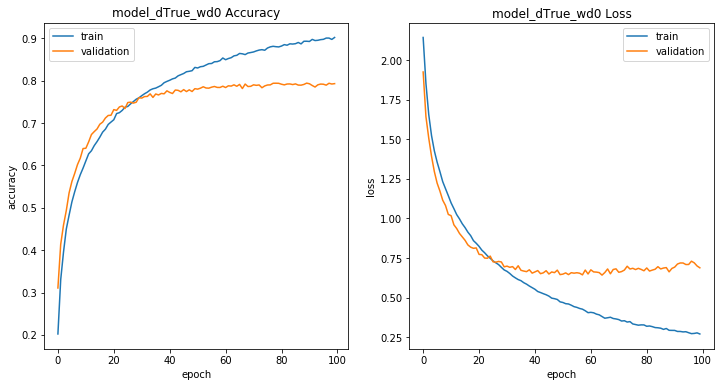

10000/10000 [==============================] - 2s 157us/step
Validation loss: 0.6884655296325684
Validation accuracy: 0.7929999828338623


In [29]:
plot_model(history_dTrue_wd0, "model_dTrue_wd0")
evaluate_model(model_dTrue_wd0)

We can see that dropout itself works better than only using weight decay. Let's see how it will work when we use both dropout and weight decay:

#### (2) dropout + weight decay (0.00005)

In [30]:
history_dTrue_wd000005, model_dTrue_wd000005 = train_model("model_dTrue_wd000005.h5", True, 0.00005)

Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 15s 363us/step - loss: 2.1308 - accuracy: 0.2080 - val_loss: 1.9501 - val_accuracy: 0.3151
Epoch 2/100
40000/40000 [==============================] - 14s 348us/step - loss: 1.9037 - accuracy: 0.3152 - val_loss: 1.7433 - val_accuracy: 0.3902
Epoch 3/100
40000/40000 [==============================] - 14s 348us/step - loss: 1.7262 - accuracy: 0.3838 - val_loss: 1.5862 - val_accuracy: 0.4289
Epoch 4/100
40000/40000 [==============================] - 14s 348us/step - loss: 1.5813 - accuracy: 0.4285 - val_loss: 1.4404 - val_accuracy: 0.4882
Epoch 5/100
40000/40000 [==============================] - 14s 347us/step - loss: 1.4788 - accuracy: 0.4683 - val_loss: 1.3450 - val_accuracy: 0.5162
Epoch 6/100
40000/40000 [==============================] - 14s 358us/step - loss: 1.4026 - accuracy: 0.4968 - val_loss: 1.2860 - val_accuracy: 0.5363
Epoch 7/100
40000/40000 [=========================

Epoch 55/100
40000/40000 [==============================] - 14s 347us/step - loss: 0.4662 - accuracy: 0.8375 - val_loss: 0.6725 - val_accuracy: 0.7788
Epoch 56/100
40000/40000 [==============================] - 14s 347us/step - loss: 0.4569 - accuracy: 0.8410 - val_loss: 0.6831 - val_accuracy: 0.7762
Epoch 57/100
40000/40000 [==============================] - 14s 347us/step - loss: 0.4583 - accuracy: 0.8402 - val_loss: 0.6817 - val_accuracy: 0.7759
Epoch 58/100
40000/40000 [==============================] - 14s 347us/step - loss: 0.4471 - accuracy: 0.8442 - val_loss: 0.6863 - val_accuracy: 0.7784
Epoch 59/100
40000/40000 [==============================] - 14s 347us/step - loss: 0.4446 - accuracy: 0.8435 - val_loss: 0.6835 - val_accuracy: 0.7721
Epoch 60/100
40000/40000 [==============================] - 14s 349us/step - loss: 0.4406 - accuracy: 0.8471 - val_loss: 0.6678 - val_accuracy: 0.7813
Epoch 61/100
40000/40000 [==============================] - 14s 347us/step - loss: 0.4321 - ac

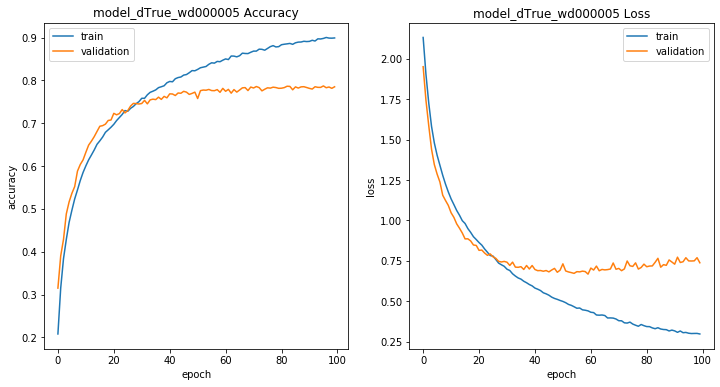

10000/10000 [==============================] - 1s 149us/step
Validation loss: 0.7379766780853272
Validation accuracy: 0.7850000262260437


In [31]:
plot_model(history_dTrue_wd000005, "model_dTrue_wd000005")
evaluate_model(model_dTrue_wd000005)

#### (3) dropout + weight decay (0.0005)

In [32]:
history_dTrue_wd00005, model_dTrue_wd00005 = train_model("model_dTrue_wd00005.h5", True, 0.0005)

Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 14s 362us/step - loss: 2.2603 - accuracy: 0.1962 - val_loss: 2.0187 - val_accuracy: 0.3053
Epoch 2/100
40000/40000 [==============================] - 14s 347us/step - loss: 1.9746 - accuracy: 0.3257 - val_loss: 1.7755 - val_accuracy: 0.3991
Epoch 3/100
40000/40000 [==============================] - 14s 347us/step - loss: 1.7874 - accuracy: 0.3873 - val_loss: 1.6669 - val_accuracy: 0.4368
Epoch 4/100
40000/40000 [==============================] - 14s 348us/step - loss: 1.6797 - accuracy: 0.4300 - val_loss: 1.5591 - val_accuracy: 0.4761
Epoch 5/100
40000/40000 [==============================] - 14s 347us/step - loss: 1.5844 - accuracy: 0.4656 - val_loss: 1.5069 - val_accuracy: 0.5030
Epoch 6/100
40000/40000 [==============================] - 14s 348us/step - loss: 1.5029 - accuracy: 0.4954 - val_loss: 1.4163 - val_accuracy: 0.5312
Epoch 7/100
40000/40000 [=========================

Epoch 55/100
40000/40000 [==============================] - 14s 348us/step - loss: 0.5796 - accuracy: 0.8407 - val_loss: 0.7984 - val_accuracy: 0.7761
Epoch 56/100
40000/40000 [==============================] - 14s 349us/step - loss: 0.5780 - accuracy: 0.8383 - val_loss: 0.7954 - val_accuracy: 0.7751
Epoch 57/100
40000/40000 [==============================] - 14s 348us/step - loss: 0.5716 - accuracy: 0.8423 - val_loss: 0.8223 - val_accuracy: 0.7716
Epoch 58/100
40000/40000 [==============================] - 14s 348us/step - loss: 0.5634 - accuracy: 0.8450 - val_loss: 0.8072 - val_accuracy: 0.7774
Epoch 59/100
40000/40000 [==============================] - 14s 348us/step - loss: 0.5593 - accuracy: 0.8474 - val_loss: 0.8072 - val_accuracy: 0.7754
Epoch 60/100
40000/40000 [==============================] - 14s 352us/step - loss: 0.5589 - accuracy: 0.8486 - val_loss: 0.8238 - val_accuracy: 0.7730
Epoch 61/100
40000/40000 [==============================] - 14s 352us/step - loss: 0.5510 - ac

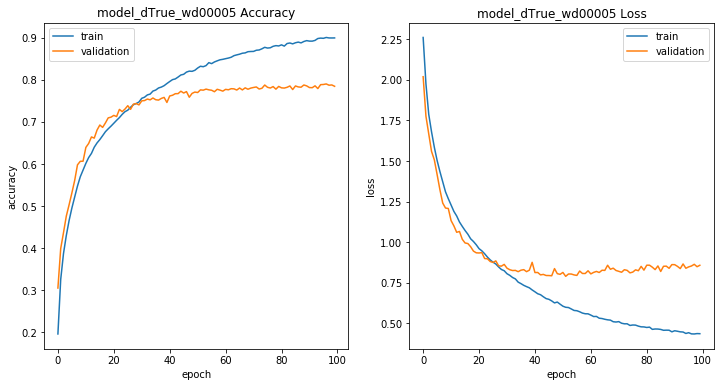

10000/10000 [==============================] - 1s 145us/step
Validation loss: 0.8577352219581604
Validation accuracy: 0.784500002861023


In [33]:
plot_model(history_dTrue_wd00005, "model_dTrue_wd00005")
evaluate_model(model_dTrue_wd00005)

#### (4) dropout + weight decay (0.005)

In [34]:
history_dTrue_wd0005, model_dTrue_wd0005 = train_model("model_dTrue_wd0005.h5", True, 0.005)

Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 15s 363us/step - loss: 3.1036 - accuracy: 0.2070 - val_loss: 2.8425 - val_accuracy: 0.3140
Epoch 2/100
40000/40000 [==============================] - 14s 349us/step - loss: 2.7638 - accuracy: 0.3176 - val_loss: 2.5574 - val_accuracy: 0.3867
Epoch 3/100
40000/40000 [==============================] - 14s 349us/step - loss: 2.5022 - accuracy: 0.3830 - val_loss: 2.3073 - val_accuracy: 0.4335
Epoch 4/100
40000/40000 [==============================] - 14s 358us/step - loss: 2.3116 - accuracy: 0.4175 - val_loss: 2.1771 - val_accuracy: 0.4525
Epoch 5/100
40000/40000 [==============================] - 14s 351us/step - loss: 2.1580 - accuracy: 0.4487 - val_loss: 2.0283 - val_accuracy: 0.4903
Epoch 6/100
40000/40000 [==============================] - 14s 360us/step - loss: 2.0356 - accuracy: 0.4730 - val_loss: 1.9102 - val_accuracy: 0.5061
Epoch 7/100
40000/40000 [=========================

Epoch 55/100
40000/40000 [==============================] - 14s 349us/step - loss: 1.0302 - accuracy: 0.7708 - val_loss: 1.0931 - val_accuracy: 0.7489
Epoch 56/100
40000/40000 [==============================] - 14s 349us/step - loss: 1.0306 - accuracy: 0.7696 - val_loss: 1.1036 - val_accuracy: 0.7459
Epoch 57/100
40000/40000 [==============================] - 14s 348us/step - loss: 1.0287 - accuracy: 0.7707 - val_loss: 1.0945 - val_accuracy: 0.7531
Epoch 58/100
40000/40000 [==============================] - 14s 350us/step - loss: 1.0277 - accuracy: 0.7734 - val_loss: 1.0935 - val_accuracy: 0.7519
Epoch 59/100
40000/40000 [==============================] - 14s 349us/step - loss: 1.0233 - accuracy: 0.7760 - val_loss: 1.1107 - val_accuracy: 0.7457
Epoch 60/100
40000/40000 [==============================] - 14s 351us/step - loss: 1.0212 - accuracy: 0.7771 - val_loss: 1.1153 - val_accuracy: 0.7449
Epoch 61/100
40000/40000 [==============================] - 14s 349us/step - loss: 1.0216 - ac

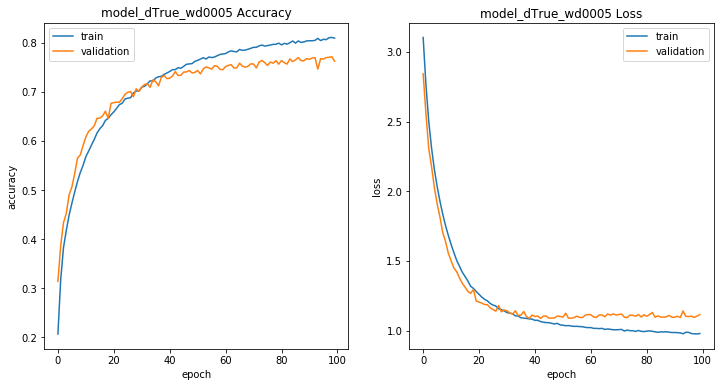

10000/10000 [==============================] - 2s 156us/step
Validation loss: 1.1144103435516357
Validation accuracy: 0.7623000144958496


In [35]:
plot_model(history_dTrue_wd0005, "model_dTrue_wd0005")
evaluate_model(model_dTrue_wd0005)

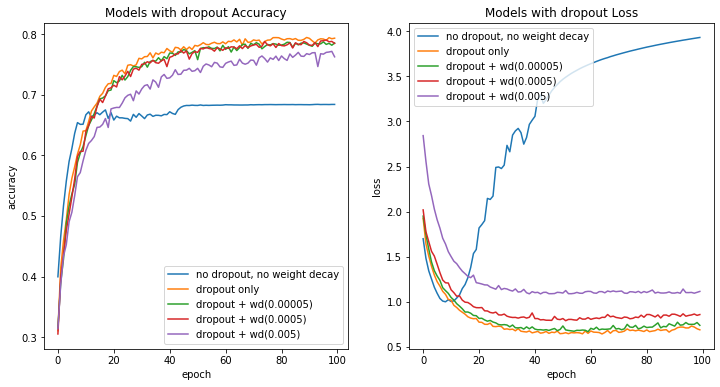

In [48]:
plot_all_models(history_dFalse_wd0, history_dTrue_wd0, history_dTrue_wd000005, history_dTrue_wd00005, history_dTrue_wd0005, 'Models with dropout', 'no dropout, no weight decay', 'dropout only', 'dropout + wd(0.00005)', 'dropout + wd(0.0005)', 'dropout + wd(0.005)')

From the graph above we can see that the validation result is the best when we only use dropout as regularization technique. I think the reason is that it's easier to get underfit when we use both techniques. Therefore, we will use only dropout as regularization technique in the following experiments.

To learn what is the best dropout rate and dropout pattern. We can now do the further research. The dropout rate and pattern I choose to use is from this paper: `Analysis on the Dropout Effect in Convolutional
Neural Networks` (http://mipal.snu.ac.kr/images/1/16/Dropout_ACCV2016.pdf).

### 3. dropout rate

First, we rewrite the build_model and train_model functions to get the dropout pattern and dropout rate as the parameters.

In [56]:
def build_model(dropout_increasing = False, dropout_rate = 0.1):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same',
                     input_shape=x_train.shape[1:]))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout_rate))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    if dropout_increasing: 
        model.add(Dropout(dropout_rate + 0.1))
    else:
        model.add(Dropout(dropout_rate))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation('relu'))
    if dropout_increasing: 
        model.add(Dropout(dropout_rate + 0.2))
    else:
        model.add(Dropout(dropout_rate))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    
    return model

In [57]:
# Let's train the model
def train_model(model_name, dropout_increasing = False, dropout_rate = 0.1):
    model = build_model(dropout_increasing, dropout_rate)
    
    # initiate optimizers
    opt = SGD(lr=0.001, momentum=0.9, decay=1e-6, nesterov=False)

    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

    train_history = model.fit(x_train, 
                              y_train,
                              batch_size=batch_size,
                              epochs=epochs,
                              validation_data=(x_validation, y_validation))

    save_model(model = model, model_name = model_name)
    
    return train_history,model

#### (1) consistent dropout, rate = 0.2

In [58]:
history_diFalse_dr02, model_diFalse_dr02 = train_model("model_diFalse_dr02.h5", False, 0.2)

Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 14s 351us/step - loss: 2.1091 - accuracy: 0.2238 - val_loss: 1.8562 - val_accuracy: 0.3450
Epoch 2/100
40000/40000 [==============================] - 13s 332us/step - loss: 1.7969 - accuracy: 0.3573 - val_loss: 1.6280 - val_accuracy: 0.4233
Epoch 3/100
40000/40000 [==============================] - 13s 332us/step - loss: 1.6178 - accuracy: 0.4191 - val_loss: 1.4992 - val_accuracy: 0.4591
Epoch 4/100
40000/40000 [==============================] - 13s 332us/step - loss: 1.5040 - accuracy: 0.4573 - val_loss: 1.4158 - val_accuracy: 0.4905
Epoch 5/100
40000/40000 [==============================] - 13s 332us/step - loss: 1.4195 - accuracy: 0.4896 - val_loss: 1.3734 - val_accuracy: 0.5056
Epoch 6/100
40000/40000 [==============================] - 14s 340us/step - loss: 1.3415 - accuracy: 0.5155 - val_loss: 1.2640 - val_accuracy: 0.5412
Epoch 7/100
40000/40000 [=========================

Epoch 55/100
40000/40000 [==============================] - 13s 332us/step - loss: 0.2238 - accuracy: 0.9197 - val_loss: 0.8939 - val_accuracy: 0.7529
Epoch 56/100
40000/40000 [==============================] - 13s 332us/step - loss: 0.2151 - accuracy: 0.9223 - val_loss: 0.9251 - val_accuracy: 0.7538
Epoch 57/100
40000/40000 [==============================] - 13s 331us/step - loss: 0.2204 - accuracy: 0.9204 - val_loss: 0.9185 - val_accuracy: 0.7561
Epoch 58/100
40000/40000 [==============================] - 13s 332us/step - loss: 0.2171 - accuracy: 0.9218 - val_loss: 0.9017 - val_accuracy: 0.7590
Epoch 59/100
40000/40000 [==============================] - 13s 332us/step - loss: 0.2047 - accuracy: 0.9265 - val_loss: 0.9097 - val_accuracy: 0.7540
Epoch 60/100
40000/40000 [==============================] - 13s 332us/step - loss: 0.2022 - accuracy: 0.9288 - val_loss: 0.9140 - val_accuracy: 0.7525
Epoch 61/100
40000/40000 [==============================] - 13s 331us/step - loss: 0.1878 - ac

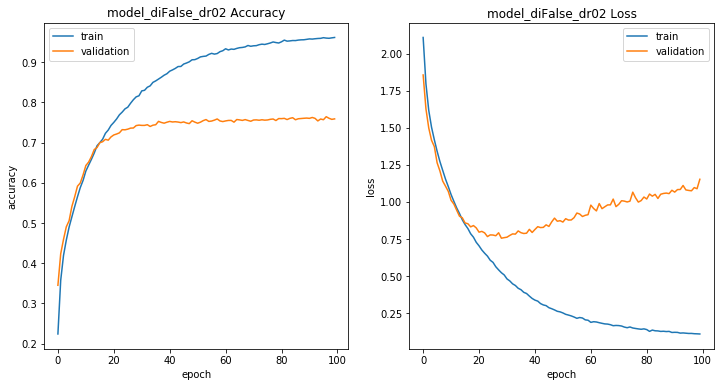

10000/10000 [==============================] - 1s 149us/step
Validation loss: 1.1527429985046387
Validation accuracy: 0.7591999769210815


In [59]:
plot_model(history_diFalse_dr02, "model_diFalse_dr02")
evaluate_model(model_diFalse_dr02)

#### (2) consistent dropout, rate = 0.3

In [60]:
history_diFalse_dr03, model_diFalse_dr03 = train_model("model_diFalse_dr03.h5", False, 0.3)

Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 14s 348us/step - loss: 2.0992 - accuracy: 0.2211 - val_loss: 1.8863 - val_accuracy: 0.3336
Epoch 2/100
40000/40000 [==============================] - 13s 332us/step - loss: 1.7791 - accuracy: 0.3555 - val_loss: 1.6203 - val_accuracy: 0.4224
Epoch 3/100
40000/40000 [==============================] - 13s 332us/step - loss: 1.6098 - accuracy: 0.4142 - val_loss: 1.4713 - val_accuracy: 0.4645
Epoch 4/100
40000/40000 [==============================] - 13s 333us/step - loss: 1.4926 - accuracy: 0.4573 - val_loss: 1.3820 - val_accuracy: 0.5058
Epoch 5/100
40000/40000 [==============================] - 13s 332us/step - loss: 1.3959 - accuracy: 0.4954 - val_loss: 1.2733 - val_accuracy: 0.5475
Epoch 6/100
40000/40000 [==============================] - 13s 333us/step - loss: 1.3206 - accuracy: 0.5251 - val_loss: 1.2042 - val_accuracy: 0.5710
Epoch 7/100
40000/40000 [=========================

Epoch 55/100
40000/40000 [==============================] - 13s 332us/step - loss: 0.3842 - accuracy: 0.8609 - val_loss: 0.6625 - val_accuracy: 0.7844
Epoch 56/100
40000/40000 [==============================] - 13s 332us/step - loss: 0.3821 - accuracy: 0.8625 - val_loss: 0.6971 - val_accuracy: 0.7770
Epoch 57/100
40000/40000 [==============================] - 14s 340us/step - loss: 0.3692 - accuracy: 0.8672 - val_loss: 0.7075 - val_accuracy: 0.7754
Epoch 58/100
40000/40000 [==============================] - 13s 332us/step - loss: 0.3696 - accuracy: 0.8652 - val_loss: 0.6517 - val_accuracy: 0.7867
Epoch 59/100
40000/40000 [==============================] - 13s 332us/step - loss: 0.3621 - accuracy: 0.8684 - val_loss: 0.6597 - val_accuracy: 0.7852
Epoch 60/100
40000/40000 [==============================] - 13s 332us/step - loss: 0.3548 - accuracy: 0.8699 - val_loss: 0.6658 - val_accuracy: 0.7864
Epoch 61/100
40000/40000 [==============================] - 13s 332us/step - loss: 0.3511 - ac

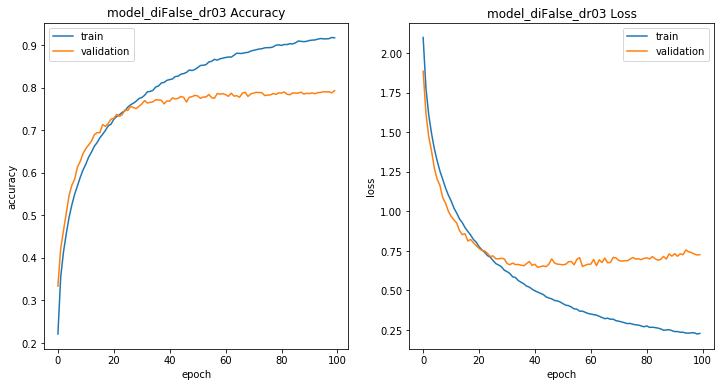

10000/10000 [==============================] - 1s 149us/step
Validation loss: 0.7263317880153656
Validation accuracy: 0.79339998960495


In [61]:
plot_model(history_diFalse_dr03, "model_diFalse_dr03")
evaluate_model(model_diFalse_dr03)

#### (3) consistent dropout, rate = 0.4

In [62]:
history_diFalse_dr04, model_diFalse_dr04 = train_model("model_diFalse_dr04.h5", False, 0.4)

Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 14s 352us/step - loss: 2.1360 - accuracy: 0.2008 - val_loss: 1.9479 - val_accuracy: 0.3002
Epoch 2/100
40000/40000 [==============================] - 14s 338us/step - loss: 1.8453 - accuracy: 0.3287 - val_loss: 1.6454 - val_accuracy: 0.4094
Epoch 3/100
40000/40000 [==============================] - 14s 340us/step - loss: 1.6788 - accuracy: 0.3869 - val_loss: 1.6344 - val_accuracy: 0.4083
Epoch 4/100
40000/40000 [==============================] - 13s 334us/step - loss: 1.5644 - accuracy: 0.4278 - val_loss: 1.4379 - val_accuracy: 0.4840
Epoch 5/100
40000/40000 [==============================] - 13s 336us/step - loss: 1.4618 - accuracy: 0.4696 - val_loss: 1.3394 - val_accuracy: 0.5151
Epoch 6/100
40000/40000 [==============================] - 14s 340us/step - loss: 1.3875 - accuracy: 0.4996 - val_loss: 1.2702 - val_accuracy: 0.5481
Epoch 7/100
40000/40000 [=========================

Epoch 55/100
40000/40000 [==============================] - 13s 335us/step - loss: 0.5678 - accuracy: 0.7970 - val_loss: 0.6231 - val_accuracy: 0.7817
Epoch 56/100
40000/40000 [==============================] - 13s 335us/step - loss: 0.5608 - accuracy: 0.7968 - val_loss: 0.6305 - val_accuracy: 0.7824
Epoch 57/100
40000/40000 [==============================] - 13s 335us/step - loss: 0.5565 - accuracy: 0.8017 - val_loss: 0.6147 - val_accuracy: 0.7882
Epoch 58/100
40000/40000 [==============================] - 13s 335us/step - loss: 0.5495 - accuracy: 0.8014 - val_loss: 0.6438 - val_accuracy: 0.7792
Epoch 59/100
40000/40000 [==============================] - 13s 335us/step - loss: 0.5439 - accuracy: 0.8033 - val_loss: 0.6150 - val_accuracy: 0.7907
Epoch 60/100
40000/40000 [==============================] - 13s 335us/step - loss: 0.5367 - accuracy: 0.8081 - val_loss: 0.6390 - val_accuracy: 0.7825
Epoch 61/100
40000/40000 [==============================] - 14s 341us/step - loss: 0.5311 - ac

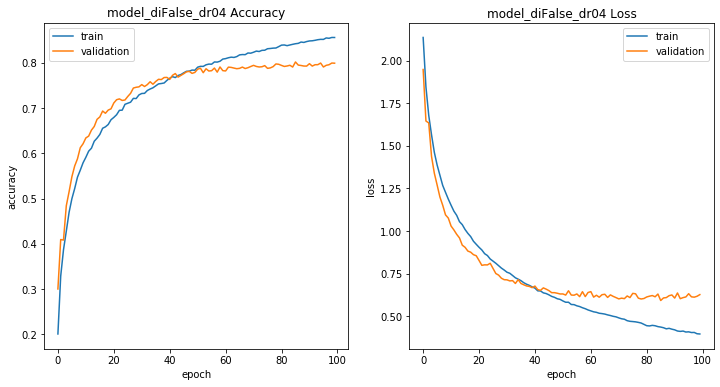

10000/10000 [==============================] - 1s 148us/step
Validation loss: 0.6265376609325409
Validation accuracy: 0.7990000247955322


In [63]:
plot_model(history_diFalse_dr04, "model_diFalse_dr04")
evaluate_model(model_diFalse_dr04)

#### (4) increasing dropout rate, rate = 0.1, 0.2, 0.3

In [64]:
history_diTrue_dr01, model_diTrue_dr01 = train_model("model_diTrue_dr01.h5", True, 0.1)

Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 14s 353us/step - loss: 2.1213 - accuracy: 0.2133 - val_loss: 1.8624 - val_accuracy: 0.3337
Epoch 2/100
40000/40000 [==============================] - 13s 335us/step - loss: 1.7774 - accuracy: 0.3592 - val_loss: 1.5820 - val_accuracy: 0.4342
Epoch 3/100
40000/40000 [==============================] - 13s 336us/step - loss: 1.5949 - accuracy: 0.4216 - val_loss: 1.4785 - val_accuracy: 0.4682
Epoch 4/100
40000/40000 [==============================] - 13s 336us/step - loss: 1.4693 - accuracy: 0.4701 - val_loss: 1.3708 - val_accuracy: 0.5084
Epoch 5/100
40000/40000 [==============================] - 13s 336us/step - loss: 1.3598 - accuracy: 0.5122 - val_loss: 1.2546 - val_accuracy: 0.5465
Epoch 6/100
40000/40000 [==============================] - 13s 336us/step - loss: 1.2779 - accuracy: 0.5445 - val_loss: 1.1948 - val_accuracy: 0.5756
Epoch 7/100
40000/40000 [=========================

Epoch 55/100
40000/40000 [==============================] - 13s 335us/step - loss: 0.2523 - accuracy: 0.9082 - val_loss: 0.8796 - val_accuracy: 0.7517
Epoch 56/100
40000/40000 [==============================] - 13s 336us/step - loss: 0.2464 - accuracy: 0.9090 - val_loss: 0.8977 - val_accuracy: 0.7551
Epoch 57/100
40000/40000 [==============================] - 13s 336us/step - loss: 0.2374 - accuracy: 0.9151 - val_loss: 0.8704 - val_accuracy: 0.7542
Epoch 58/100
40000/40000 [==============================] - 13s 335us/step - loss: 0.2302 - accuracy: 0.9172 - val_loss: 0.9437 - val_accuracy: 0.7514
Epoch 59/100
40000/40000 [==============================] - 13s 336us/step - loss: 0.2263 - accuracy: 0.9175 - val_loss: 0.9000 - val_accuracy: 0.7518
Epoch 60/100
40000/40000 [==============================] - 13s 336us/step - loss: 0.2244 - accuracy: 0.9189 - val_loss: 0.9069 - val_accuracy: 0.7456
Epoch 61/100
40000/40000 [==============================] - 14s 345us/step - loss: 0.2158 - ac

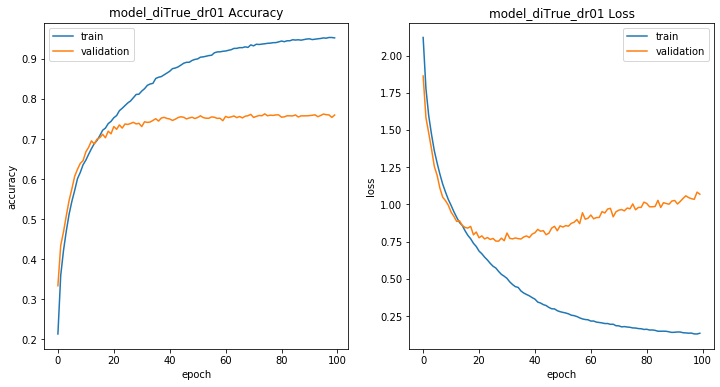

10000/10000 [==============================] - 1s 145us/step
Validation loss: 1.0680659964561463
Validation accuracy: 0.7597000002861023


In [65]:
plot_model(history_diTrue_dr01, "model_diTrue_dr01")
evaluate_model(model_diTrue_dr01)

#### (5) increasing dropout rate, rate = 0.2, 0.3, 0.4

In [66]:
history_diTrue_dr02, model_diTrue_dr02 = train_model("model_diTrue_dr02.h5", True, 0.2)

Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 14s 362us/step - loss: 2.1518 - accuracy: 0.1991 - val_loss: 1.9128 - val_accuracy: 0.3140
Epoch 2/100
40000/40000 [==============================] - 14s 341us/step - loss: 1.8818 - accuracy: 0.3248 - val_loss: 1.6821 - val_accuracy: 0.3954
Epoch 3/100
40000/40000 [==============================] - 14s 338us/step - loss: 1.6979 - accuracy: 0.3882 - val_loss: 1.5795 - val_accuracy: 0.4300
Epoch 4/100
40000/40000 [==============================] - 14s 338us/step - loss: 1.5949 - accuracy: 0.4244 - val_loss: 1.4765 - val_accuracy: 0.4721
Epoch 5/100
40000/40000 [==============================] - 14s 338us/step - loss: 1.5084 - accuracy: 0.4536 - val_loss: 1.4048 - val_accuracy: 0.4887
Epoch 6/100
40000/40000 [==============================] - 14s 346us/step - loss: 1.4329 - accuracy: 0.4830 - val_loss: 1.3183 - val_accuracy: 0.5268
Epoch 7/100
40000/40000 [=========================

Epoch 55/100
40000/40000 [==============================] - 14s 338us/step - loss: 0.4536 - accuracy: 0.8361 - val_loss: 0.6859 - val_accuracy: 0.7741
Epoch 56/100
40000/40000 [==============================] - 14s 338us/step - loss: 0.4460 - accuracy: 0.8396 - val_loss: 0.6952 - val_accuracy: 0.7691
Epoch 57/100
40000/40000 [==============================] - 14s 338us/step - loss: 0.4451 - accuracy: 0.8385 - val_loss: 0.6767 - val_accuracy: 0.7784
Epoch 58/100
40000/40000 [==============================] - 14s 338us/step - loss: 0.4334 - accuracy: 0.8418 - val_loss: 0.6816 - val_accuracy: 0.7765
Epoch 59/100
40000/40000 [==============================] - 14s 338us/step - loss: 0.4319 - accuracy: 0.8435 - val_loss: 0.6741 - val_accuracy: 0.7736
Epoch 60/100
40000/40000 [==============================] - 14s 338us/step - loss: 0.4218 - accuracy: 0.8481 - val_loss: 0.6861 - val_accuracy: 0.7750
Epoch 61/100
40000/40000 [==============================] - 14s 339us/step - loss: 0.4183 - ac

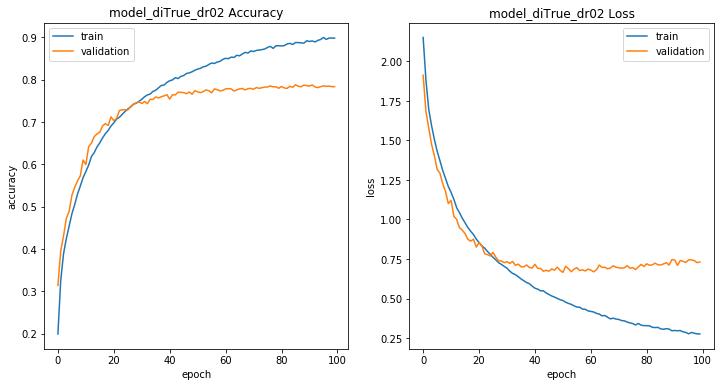

10000/10000 [==============================] - 2s 152us/step
Validation loss: 0.7315701578140259
Validation accuracy: 0.7836999893188477


In [67]:
plot_model(history_diTrue_dr02, "model_diTrue_dr02")
evaluate_model(model_diTrue_dr02)

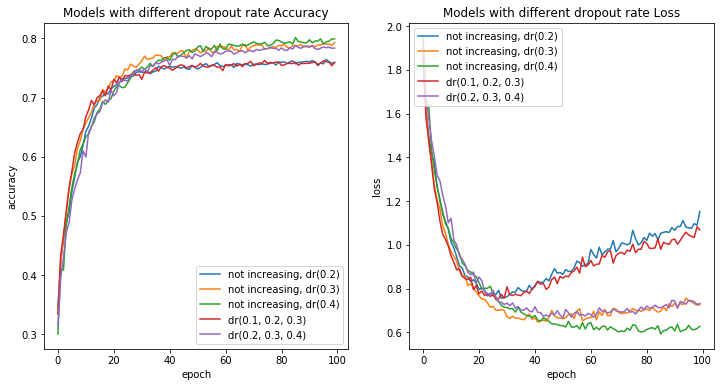

In [68]:
plot_all_models(history_diFalse_dr02, history_diFalse_dr03, history_diFalse_dr04, history_diTrue_dr01, history_diTrue_dr02, 'Models with different dropout rate', 'not increasing, dr(0.2)', 'not increasing, dr(0.3)', 'not increasing, dr(0.4)', 'dr(0.1, 0.2, 0.3)', 'dr(0.2, 0.3, 0.4)')

From the results we can see that consistent dropout rate 0.4 generate the best result on the validation set. Thus, we will use this dropout rate in the following experiments.


## Section 2. Network structure
### Number of blocks of the network

#### 3 blocks

In [71]:
def build_model(dropout_increasing = False, dropout_rate = 0.1):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same',
                     input_shape=x_train.shape[1:]))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout_rate))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout_rate))
    
    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout_rate))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    
    return model

In [72]:
history_3blocks_dr04, model_3blocks_dr04 = train_model("model_3blocks_dr04.h5", False, 0.4)

Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 20s 509us/step - loss: 2.2323 - accuracy: 0.1643 - val_loss: 2.1040 - val_accuracy: 0.2409
Epoch 2/100
40000/40000 [==============================] - 19s 480us/step - loss: 2.0254 - accuracy: 0.2522 - val_loss: 1.9656 - val_accuracy: 0.2837
Epoch 3/100
40000/40000 [==============================] - 19s 481us/step - loss: 1.8568 - accuracy: 0.3065 - val_loss: 1.7161 - val_accuracy: 0.3640
Epoch 4/100
40000/40000 [==============================] - 19s 480us/step - loss: 1.7417 - accuracy: 0.3516 - val_loss: 1.6519 - val_accuracy: 0.3877
Epoch 5/100
40000/40000 [==============================] - 19s 481us/step - loss: 1.6530 - accuracy: 0.3866 - val_loss: 1.5069 - val_accuracy: 0.4508
Epoch 6/100
40000/40000 [==============================] - 20s 489us/step - loss: 1.5671 - accuracy: 0.4255 - val_loss: 1.4386 - val_accuracy: 0.4717
Epoch 7/100
40000/40000 [=========================

Epoch 55/100
40000/40000 [==============================] - 19s 481us/step - loss: 0.6254 - accuracy: 0.7799 - val_loss: 0.6012 - val_accuracy: 0.7885
Epoch 56/100
40000/40000 [==============================] - 19s 474us/step - loss: 0.6197 - accuracy: 0.7809 - val_loss: 0.5962 - val_accuracy: 0.7922
Epoch 57/100
40000/40000 [==============================] - 19s 472us/step - loss: 0.6103 - accuracy: 0.7851 - val_loss: 0.5984 - val_accuracy: 0.7933
Epoch 58/100
40000/40000 [==============================] - 19s 477us/step - loss: 0.6045 - accuracy: 0.7881 - val_loss: 0.5665 - val_accuracy: 0.8001
Epoch 59/100
40000/40000 [==============================] - 19s 473us/step - loss: 0.5993 - accuracy: 0.7891 - val_loss: 0.5811 - val_accuracy: 0.7960
Epoch 60/100
40000/40000 [==============================] - 19s 473us/step - loss: 0.5945 - accuracy: 0.7903 - val_loss: 0.6003 - val_accuracy: 0.7896
Epoch 61/100
40000/40000 [==============================] - 19s 473us/step - loss: 0.5950 - ac

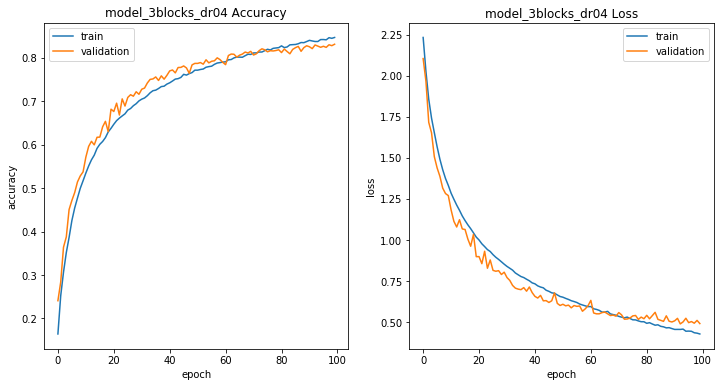

10000/10000 [==============================] - 2s 195us/step
Validation loss: 0.49137223253250123
Validation accuracy: 0.8313999772071838


In [73]:
plot_model(history_3blocks_dr04, "model_3blocks_dr04")
evaluate_model(model_3blocks_dr04)

#### 4 blocks

In [76]:
def build_model(dropout_increasing = False, dropout_rate = 0.1):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same',
                     input_shape=x_train.shape[1:]))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout_rate))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout_rate))
    
    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout_rate))
    
    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout_rate))

    model.add(Flatten())
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    
    return model

In [77]:
history_4blocks_dr04, model_4blocks_dr04 = train_model("model_4blocks_dr04.h5", False, 0.4)

Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 27s 673us/step - loss: 2.2687 - accuracy: 0.1337 - val_loss: 2.1689 - val_accuracy: 0.2240
Epoch 2/100
40000/40000 [==============================] - 26s 648us/step - loss: 2.0857 - accuracy: 0.2275 - val_loss: 1.9968 - val_accuracy: 0.2623
Epoch 3/100
40000/40000 [==============================] - 26s 650us/step - loss: 1.9405 - accuracy: 0.2658 - val_loss: 1.8695 - val_accuracy: 0.2961
Epoch 4/100
40000/40000 [==============================] - 26s 653us/step - loss: 1.8095 - accuracy: 0.3070 - val_loss: 1.8679 - val_accuracy: 0.3070
Epoch 5/100
40000/40000 [==============================] - 26s 647us/step - loss: 1.7007 - accuracy: 0.3512 - val_loss: 1.6251 - val_accuracy: 0.3871
Epoch 6/100
40000/40000 [==============================] - 26s 647us/step - loss: 1.6062 - accuracy: 0.3937 - val_loss: 1.4929 - val_accuracy: 0.4383
Epoch 7/100
40000/40000 [=========================

Epoch 55/100
40000/40000 [==============================] - 26s 646us/step - loss: 0.5578 - accuracy: 0.8038 - val_loss: 0.5444 - val_accuracy: 0.8165
Epoch 56/100
40000/40000 [==============================] - 26s 647us/step - loss: 0.5509 - accuracy: 0.8078 - val_loss: 0.5580 - val_accuracy: 0.8067
Epoch 57/100
40000/40000 [==============================] - 26s 646us/step - loss: 0.5433 - accuracy: 0.8121 - val_loss: 0.5723 - val_accuracy: 0.8098
Epoch 58/100
40000/40000 [==============================] - 26s 647us/step - loss: 0.5335 - accuracy: 0.8139 - val_loss: 0.5449 - val_accuracy: 0.8138
Epoch 59/100
40000/40000 [==============================] - 26s 647us/step - loss: 0.5326 - accuracy: 0.8137 - val_loss: 0.5459 - val_accuracy: 0.8108
Epoch 60/100
40000/40000 [==============================] - 26s 648us/step - loss: 0.5183 - accuracy: 0.8203 - val_loss: 0.5434 - val_accuracy: 0.8126
Epoch 61/100
40000/40000 [==============================] - 26s 647us/step - loss: 0.5150 - ac

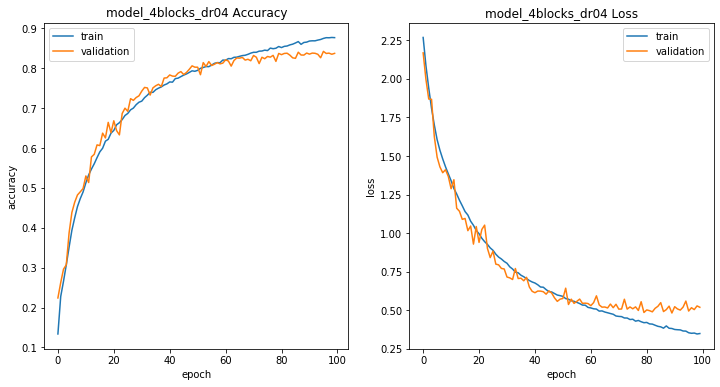

10000/10000 [==============================] - 2s 240us/step
Validation loss: 0.5191414921879768
Validation accuracy: 0.8371000289916992


In [78]:
plot_model(history_4blocks_dr04, "model_4blocks_dr04")
evaluate_model(model_4blocks_dr04)

Let's plot the result of the networks with different number of blocks in the same graph and see how the number of blocks affect the performance of the model.

In [81]:
def plot_all_models(history1, history2, history3, title, legend1, legend2, legend3):
    plt.figure(figsize=(12,6))
    # summarize history for accuracy
    plt.subplot(121)
    plt.plot(history1.history['val_accuracy'])
    plt.plot(history2.history['val_accuracy'])
    plt.plot(history3.history['val_accuracy'])
    plt.title(title + ' Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend([legend1, legend2, legend3], loc='lower right')
    # summarize history for loss
    plt.subplot(122)
    plt.plot(history1.history['val_loss'])
    plt.plot(history2.history['val_loss'])
    plt.plot(history3.history['val_loss'])

    plt.title(title+ ' Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend([legend1, legend2, legend3], loc='upper left')
    plt.show()
    return None

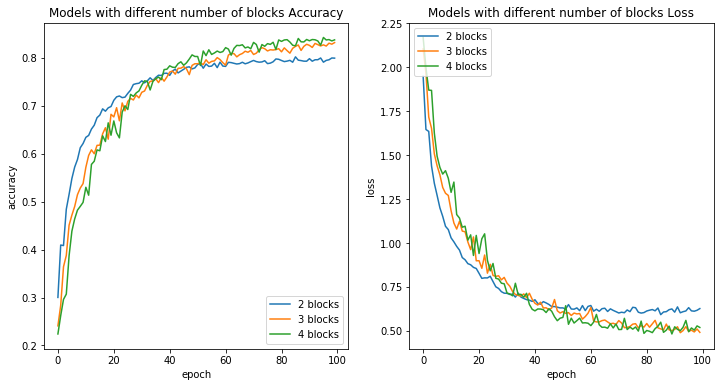

In [83]:
plot_all_models(history_diFalse_dr04, history_3blocks_dr04, history_4blocks_dr04, 'Models with different number of blocks', '2 blocks', '3 blocks', '4 blocks')

From the results we can see that 3 blocks and 4 blocks generated better results than original 2 blocks networks. However, we can not see a big difference between 3 and 4 blocks. From some of the paper researchers have demonstrate that under some limits more blocks help with the learning. But as the number of blocks increasing beyond the limit, the performance will decrease as too much unrelated features are learned by the model.

From our experiments above, we can not say 4 blocks is not better than 3 blocks. The hyperparameters we choose might be not suitable for the 4 blocks model. But for both training time and performance sake, I decided to use 3 blocks structure in the following experiments.

## Section 3. Optimizers

In [101]:
def build_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same',
                     input_shape=x_train.shape[1:]))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))
    
    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.4))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    
    return model

#### RMSprop
Rmsprop is a very clever way to deal with the problem. It uses a moving average of squared gradients to normalize the gradient itself. That has an effect of balancing the step size — decrease the step for large gradient to avoid exploding, and increase the step for small gradient to avoid vanishing.

https://www.coursera.org/learn/deep-neural-network/lecture/BhJlm/rmsprop

In [112]:
# Let's train the model
def train_model(model_name):
    model = build_model()
    
    # initiate optimizers
    opt = RMSprop(learning_rate=0.0001, decay=1e-7)

    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

    train_history = model.fit(x_train, 
                              y_train,
                              batch_size=batch_size,
                              epochs=epochs,
                              validation_data=(x_validation, y_validation))

    save_model(model = model, model_name = model_name)
    
    return train_history,model

In [113]:
history_3blocks_rms, model_3blocks_rms = train_model("model_3blocks_rms.h5")

Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 30s 754us/step - loss: 2.0382 - accuracy: 0.2290 - val_loss: 1.7532 - val_accuracy: 0.3630
Epoch 2/100
40000/40000 [==============================] - 29s 721us/step - loss: 1.7240 - accuracy: 0.3634 - val_loss: 1.5973 - val_accuracy: 0.4115
Epoch 3/100
40000/40000 [==============================] - 29s 721us/step - loss: 1.5825 - accuracy: 0.4177 - val_loss: 1.4675 - val_accuracy: 0.4610
Epoch 4/100
40000/40000 [==============================] - 29s 720us/step - loss: 1.4777 - accuracy: 0.4618 - val_loss: 1.4384 - val_accuracy: 0.4646
Epoch 5/100
40000/40000 [==============================] - 29s 720us/step - loss: 1.3999 - accuracy: 0.4953 - val_loss: 1.2703 - val_accuracy: 0.5393
Epoch 6/100
40000/40000 [==============================] - 29s 721us/step - loss: 1.3239 - accuracy: 0.5232 - val_loss: 1.1805 - val_accuracy: 0.5711
Epoch 7/100
40000/40000 [=========================

Epoch 55/100
40000/40000 [==============================] - 28s 690us/step - loss: 0.6261 - accuracy: 0.7905 - val_loss: 0.5899 - val_accuracy: 0.8047
Epoch 56/100
40000/40000 [==============================] - 28s 693us/step - loss: 0.6287 - accuracy: 0.7881 - val_loss: 0.6616 - val_accuracy: 0.7966
Epoch 57/100
40000/40000 [==============================] - 28s 690us/step - loss: 0.6227 - accuracy: 0.7915 - val_loss: 0.6451 - val_accuracy: 0.7934
Epoch 58/100
40000/40000 [==============================] - 28s 690us/step - loss: 0.6222 - accuracy: 0.7909 - val_loss: 0.5783 - val_accuracy: 0.8060
Epoch 59/100
40000/40000 [==============================] - 28s 689us/step - loss: 0.6220 - accuracy: 0.7922 - val_loss: 0.5899 - val_accuracy: 0.8028
Epoch 60/100
40000/40000 [==============================] - 28s 690us/step - loss: 0.6225 - accuracy: 0.7934 - val_loss: 0.6326 - val_accuracy: 0.8020
Epoch 61/100
40000/40000 [==============================] - 28s 689us/step - loss: 0.6210 - ac

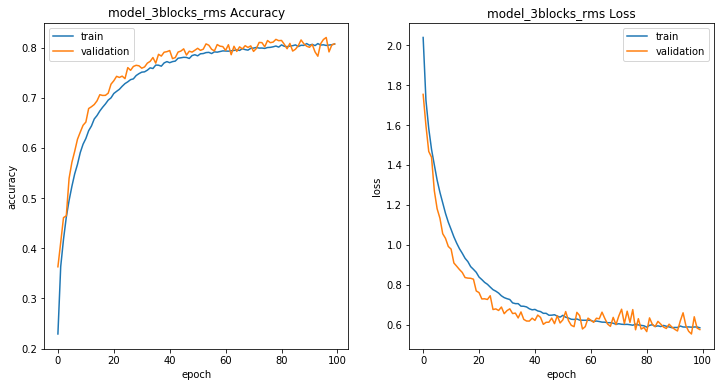

10000/10000 [==============================] - 2s 228us/step
Validation loss: 0.5753544214248657
Validation accuracy: 0.8075000047683716


In [114]:
plot_model(history_3blocks_rms, "model_3blocks_rms")
evaluate_model(model_3blocks_rms)

#### Adam
Adam can be looked at as a combination of RMSprop and Stochastic Gradient Descent with momentum. It uses the squared gradients to scale the learning rate like RMSprop and it takes advantage of momentum by using moving average of the gradient instead of gradient itself like SGD with momentum.

In [115]:
from keras.optimizers import Adam
# Let's train the model
def train_model(model_name):
    model = build_model()
    
    # initiate optimizers
    opt = Adam(learning_rate=0.0001, decay=1e-7, beta_1=0.9, beta_2=0.999, amsgrad=False)

    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

    train_history = model.fit(x_train, 
                              y_train,
                              batch_size=batch_size,
                              epochs=epochs,
                              validation_data=(x_validation, y_validation))

    save_model(model = model, model_name = model_name)
    
    return train_history,model

In [116]:
history_3blocks_adam, model_3blocks_adam = train_model("model_3blocks_adam.h5")

Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 31s 783us/step - loss: 1.9796 - accuracy: 0.2601 - val_loss: 1.6637 - val_accuracy: 0.3855
Epoch 2/100
40000/40000 [==============================] - 30s 753us/step - loss: 1.6497 - accuracy: 0.3914 - val_loss: 1.4790 - val_accuracy: 0.4606
Epoch 3/100
40000/40000 [==============================] - 30s 753us/step - loss: 1.5112 - accuracy: 0.4483 - val_loss: 1.3704 - val_accuracy: 0.4993
Epoch 4/100
40000/40000 [==============================] - 30s 753us/step - loss: 1.4188 - accuracy: 0.4850 - val_loss: 1.2803 - val_accuracy: 0.5372
Epoch 5/100
40000/40000 [==============================] - 30s 753us/step - loss: 1.3327 - accuracy: 0.5183 - val_loss: 1.2151 - val_accuracy: 0.5591
Epoch 6/100
40000/40000 [==============================] - 30s 752us/step - loss: 1.2722 - accuracy: 0.5422 - val_loss: 1.1470 - val_accuracy: 0.5861
Epoch 7/100
40000/40000 [=========================

Epoch 55/100
40000/40000 [==============================] - 30s 755us/step - loss: 0.4954 - accuracy: 0.8253 - val_loss: 0.5481 - val_accuracy: 0.8153
Epoch 56/100
40000/40000 [==============================] - 30s 753us/step - loss: 0.4903 - accuracy: 0.8249 - val_loss: 0.5607 - val_accuracy: 0.8078
Epoch 57/100
40000/40000 [==============================] - 30s 756us/step - loss: 0.4832 - accuracy: 0.8302 - val_loss: 0.5497 - val_accuracy: 0.8121
Epoch 58/100
40000/40000 [==============================] - 30s 752us/step - loss: 0.4742 - accuracy: 0.8330 - val_loss: 0.5548 - val_accuracy: 0.8130
Epoch 59/100
40000/40000 [==============================] - 30s 749us/step - loss: 0.4790 - accuracy: 0.8314 - val_loss: 0.5321 - val_accuracy: 0.8186
Epoch 60/100
40000/40000 [==============================] - 30s 754us/step - loss: 0.4656 - accuracy: 0.8346 - val_loss: 0.5462 - val_accuracy: 0.8131
Epoch 61/100
40000/40000 [==============================] - 30s 748us/step - loss: 0.4641 - ac

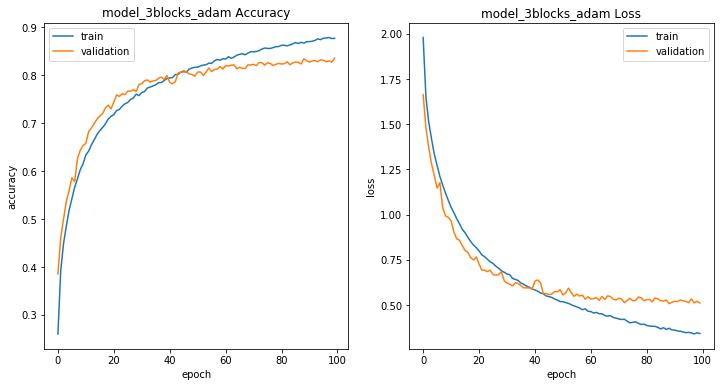

10000/10000 [==============================] - 2s 226us/step
Validation loss: 0.5111270328760147
Validation accuracy: 0.8356999754905701


In [117]:
plot_model(history_3blocks_adam, "model_3blocks_adam")
evaluate_model(model_3blocks_adam)

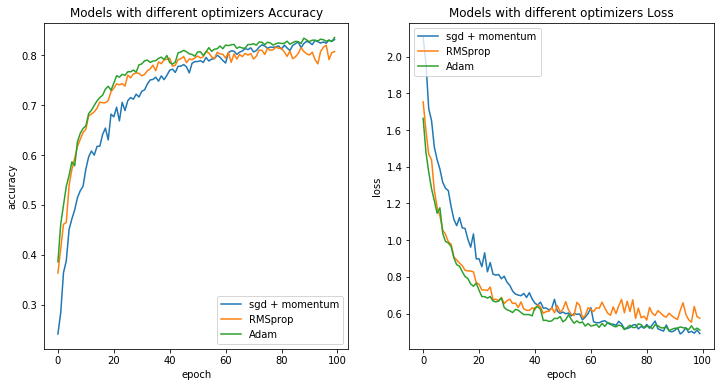

In [118]:
plot_all_models(history_3blocks_dr04, history_3blocks_rms, history_3blocks_adam, 'Models with different optimizers', 'sgd + momentum', 'RMSprop', 'Adam')

From the results above, we can notice that momentum and Adam performs slightly better than RMSprop. We can also see Adam helps the accuracy and loss converge faster even the learning rate of the model uses Adam is smaller than that with SGD and momentum. We will use Adam in the following experiments because of the quicklier convergence property.


## Section 4. Batch Normalization

Next, we can add batch normalization in an effort to stabilize the learning and perhaps accelerate the learning process. We already know that rather than having some features that range from zero to one, and some from one to a 1,000, by normalizing all the features, input features X, to take on a similar range of values that can speed up learning. So, one intuition behind why batch norm works is, this is doing a similar thing, but further values in your hidden units and not just for your input there.

In [121]:
from keras.layers import BatchNormalization
def build_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same',
                     input_shape=x_train.shape[1:]))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))
    
    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.4))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    
    return model

In [122]:
history_3blocks_adam_bn, model_3blocks_adam_bn = train_model("model_3blocks_adam_bn.h5")

Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 46s 1ms/step - loss: 2.0807 - accuracy: 0.2695 - val_loss: 2.0173 - val_accuracy: 0.2668
Epoch 2/100
40000/40000 [==============================] - 44s 1ms/step - loss: 1.6812 - accuracy: 0.3872 - val_loss: 2.2065 - val_accuracy: 0.2601
Epoch 3/100
40000/40000 [==============================] - 44s 1ms/step - loss: 1.5095 - accuracy: 0.4556 - val_loss: 1.7384 - val_accuracy: 0.3890
Epoch 4/100
40000/40000 [==============================] - 44s 1ms/step - loss: 1.3976 - accuracy: 0.4958 - val_loss: 1.4755 - val_accuracy: 0.4767
Epoch 5/100
40000/40000 [==============================] - 44s 1ms/step - loss: 1.3132 - accuracy: 0.5299 - val_loss: 1.3480 - val_accuracy: 0.5278
Epoch 6/100
40000/40000 [==============================] - 44s 1ms/step - loss: 1.2243 - accuracy: 0.5639 - val_loss: 1.3233 - val_accuracy: 0.5342
Epoch 7/100
40000/40000 [==============================] - 44s

Epoch 56/100
40000/40000 [==============================] - 44s 1ms/step - loss: 0.4740 - accuracy: 0.8347 - val_loss: 0.4757 - val_accuracy: 0.8358
Epoch 57/100
40000/40000 [==============================] - 44s 1ms/step - loss: 0.4706 - accuracy: 0.8345 - val_loss: 0.4762 - val_accuracy: 0.8372
Epoch 58/100
40000/40000 [==============================] - 44s 1ms/step - loss: 0.4704 - accuracy: 0.8371 - val_loss: 0.4538 - val_accuracy: 0.8420
Epoch 59/100
40000/40000 [==============================] - 44s 1ms/step - loss: 0.4549 - accuracy: 0.8408 - val_loss: 0.4761 - val_accuracy: 0.8326
Epoch 60/100
40000/40000 [==============================] - 44s 1ms/step - loss: 0.4581 - accuracy: 0.8406 - val_loss: 0.4464 - val_accuracy: 0.8459
Epoch 61/100
40000/40000 [==============================] - 44s 1ms/step - loss: 0.4511 - accuracy: 0.8408 - val_loss: 0.5456 - val_accuracy: 0.8179
Epoch 62/100
40000/40000 [==============================] - 44s 1ms/step - loss: 0.4490 - accuracy: 0.8419

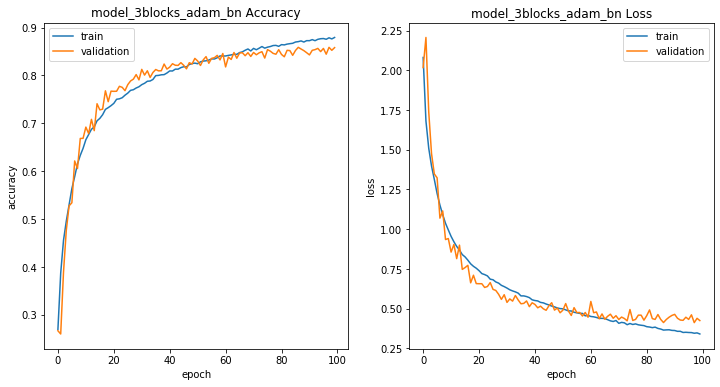

10000/10000 [==============================] - 3s 281us/step
Validation loss: 0.42531817065477373
Validation accuracy: 0.8582000136375427


In [123]:
plot_model(history_3blocks_adam_bn, "model_3blocks_adam_bn")
evaluate_model(model_3blocks_adam_bn)

We can see that with Batch Normalization, the validation accuracy rise from 83.6% to 85.8%. Therefore, we will keep this optimization in our model.

## Section 5. Data Augmentation

Data augmentation involves making copies of the examples in the training dataset with small random modifications.

This has a regularizing effect as it both expands the training dataset and allows the model to learn the same general features, although in a more generalized manner. This can be implemented in Keras using the ImageDataGenerator class.

In [130]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(width_shift_range=0.1, # randomly shift images horizontally
                             height_shift_range=0.1, # randomly shift images vertically
                             horizontal_flip=True) # randomly flip images horizontally

datagen.fit(x_train)
train_flow = datagen.flow(x_train, y_train, batch_size=batch_size)

# Let's train the model
def train_model(model_name):
    model = build_model()
    
    # initiate optimizers
    opt = Adam(learning_rate=0.0001, decay=1e-7, beta_1=0.9, beta_2=0.999, amsgrad=False)

    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

    train_history = model.fit_generator(train_flow,
                              epochs=epochs,
                              validation_data=(x_validation, y_validation))

    save_model(model = model, model_name = model_name)
    
    return train_history,model

In [131]:
history_3blocks_adam_bn_da, model_3blocks_adam_bn_da = train_model("model_3blocks_adam_bn_da.h5")

Epoch 1/100
1250/1250 [==============================] - 46s 37ms/step - loss: 2.1843 - accuracy: 0.2405 - val_loss: 1.9572 - val_accuracy: 0.2839
Epoch 2/100
1250/1250 [==============================] - 43s 35ms/step - loss: 1.7669 - accuracy: 0.3562 - val_loss: 1.8439 - val_accuracy: 0.3467
Epoch 3/100
1250/1250 [==============================] - 43s 35ms/step - loss: 1.6189 - accuracy: 0.4088 - val_loss: 1.7023 - val_accuracy: 0.3898
Epoch 4/100
1250/1250 [==============================] - 43s 35ms/step - loss: 1.5251 - accuracy: 0.4433 - val_loss: 1.5275 - val_accuracy: 0.4465
Epoch 5/100
1250/1250 [==============================] - 43s 35ms/step - loss: 1.4502 - accuracy: 0.4755 - val_loss: 1.6018 - val_accuracy: 0.4368
Epoch 6/100
1250/1250 [==============================] - 43s 35ms/step - loss: 1.3859 - accuracy: 0.4972 - val_loss: 1.3665 - val_accuracy: 0.5110
Epoch 7/100
1250/1250 [==============================] - 43s 35ms/step - loss: 1.3086 - accuracy: 0.5271 - val_loss: 1

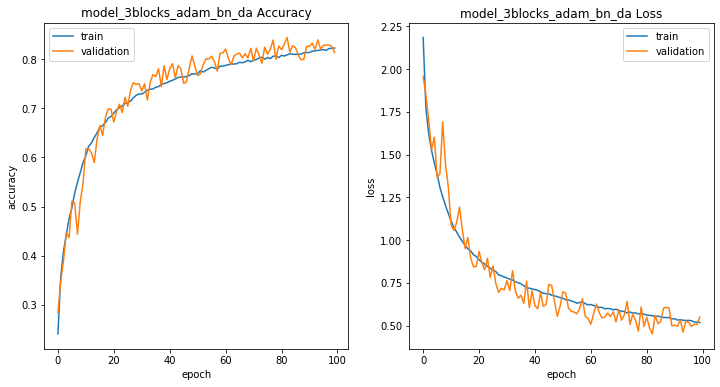

10000/10000 [==============================] - 3s 293us/step
Validation loss: 0.5509360216379166
Validation accuracy: 0.8133999705314636


In [132]:
plot_model(history_3blocks_adam_bn_da, "model_3blocks_adam_bn_da")
evaluate_model(model_3blocks_adam_bn_da)

From the graph above we notice that the model is still underfit with 100 epochs. Let's first see the model performances with batch normalization and data augmentation.

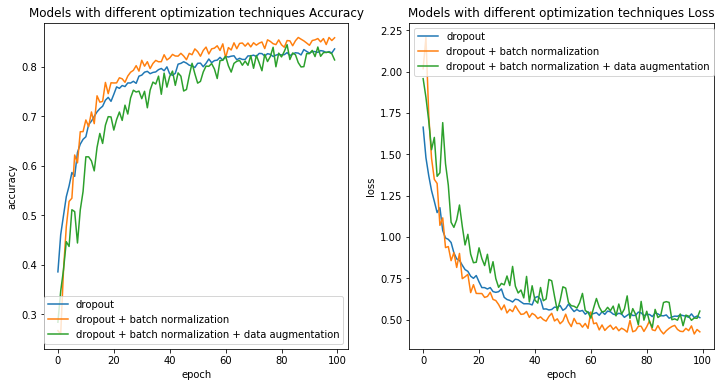

In [145]:
plot_all_models(history_3blocks_adam, history_3blocks_adam_bn, history_3blocks_adam_bn_da, 'Models with different optimization techniques', 'dropout', 'dropout + batch normalization', 'dropout + batch normalization + data augmentation')

We can see that model with dropout + batch normalization + data augmentation doesn't perform better than the model with only dropout at epoch 100. However, from the previous analysis we already know that model with dropout + batch normalization + data augmentation converge slowlier and might need more epochs to converge. Let's try keep training for 100 more epochs.

In [133]:
train_history = model_3blocks_adam_bn_da.fit_generator(train_flow,
                              epochs=epochs,
                              validation_data=(x_validation, y_validation))

save_model(model = model_3blocks_adam_bn_da, model_name = "model_3blocks_adam_bn_da_200")

Epoch 1/100
1250/1250 [==============================] - 44s 35ms/step - loss: 0.5249 - accuracy: 0.8199 - val_loss: 0.5530 - val_accuracy: 0.8191
Epoch 2/100
1250/1250 [==============================] - 43s 35ms/step - loss: 0.5237 - accuracy: 0.8199 - val_loss: 0.4833 - val_accuracy: 0.8387
Epoch 3/100
1250/1250 [==============================] - 43s 35ms/step - loss: 0.5198 - accuracy: 0.8219 - val_loss: 0.4446 - val_accuracy: 0.8480
Epoch 4/100
1250/1250 [==============================] - 43s 35ms/step - loss: 0.5157 - accuracy: 0.8229 - val_loss: 0.4542 - val_accuracy: 0.8460
Epoch 5/100
1250/1250 [==============================] - 43s 35ms/step - loss: 0.5151 - accuracy: 0.8254 - val_loss: 0.4647 - val_accuracy: 0.8433
Epoch 6/100
1250/1250 [==============================] - 44s 35ms/step - loss: 0.5035 - accuracy: 0.8272 - val_loss: 0.4685 - val_accuracy: 0.8438
Epoch 7/100
1250/1250 [==============================] - 43s 35ms/step - loss: 0.5099 - accuracy: 0.8249 - val_loss: 0

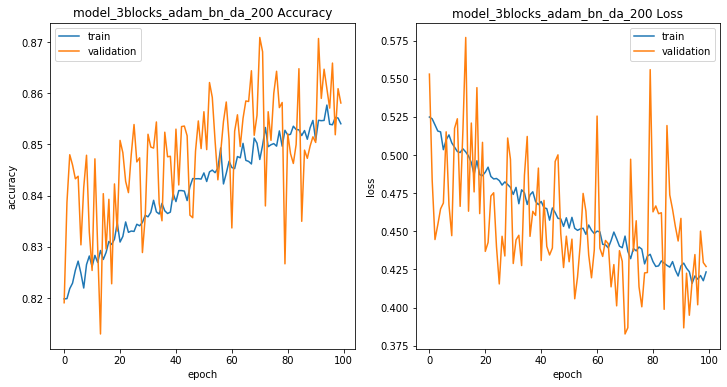

10000/10000 [==============================] - 3s 293us/step
Validation loss: 0.4269368580341339
Validation accuracy: 0.8580999970436096


In [135]:
plot_model(train_history, "model_3blocks_adam_bn_da_200")
evaluate_model(model_3blocks_adam_bn_da)

It still doesn't look like it already converged after 200 epochs. Let's keep training. This time, I choose 300 more epochs to give it enough steps to converge.

In [137]:
train_history_200_500 = model_3blocks_adam_bn_da.fit_generator(train_flow,
                              epochs=300,
                              validation_data=(x_validation, y_validation))

save_model(model = model_3blocks_adam_bn_da, model_name = "model_3blocks_adam_bn_da_500")

Epoch 1/300
1250/1250 [==============================] - 43s 35ms/step - loss: 0.4164 - accuracy: 0.8564 - val_loss: 0.4617 - val_accuracy: 0.8519
Epoch 2/300
1250/1250 [==============================] - 43s 35ms/step - loss: 0.4166 - accuracy: 0.8541 - val_loss: 0.4270 - val_accuracy: 0.8592
Epoch 3/300
1250/1250 [==============================] - 44s 35ms/step - loss: 0.4178 - accuracy: 0.8568 - val_loss: 0.4071 - val_accuracy: 0.8643
Epoch 4/300
1250/1250 [==============================] - 43s 35ms/step - loss: 0.4167 - accuracy: 0.8574 - val_loss: 0.4466 - val_accuracy: 0.8524
Epoch 5/300
1250/1250 [==============================] - 43s 35ms/step - loss: 0.4204 - accuracy: 0.8553 - val_loss: 0.4452 - val_accuracy: 0.8528
Epoch 6/300
1250/1250 [==============================] - 43s 35ms/step - loss: 0.4172 - accuracy: 0.8573 - val_loss: 0.4063 - val_accuracy: 0.8642
Epoch 7/300
1250/1250 [==============================] - 43s 35ms/step - loss: 0.4101 - accuracy: 0.8574 - val_loss: 0

1250/1250 [==============================] - 43s 35ms/step - loss: 0.3736 - accuracy: 0.8694 - val_loss: 0.4006 - val_accuracy: 0.8702
Epoch 112/300
1250/1250 [==============================] - 43s 35ms/step - loss: 0.3727 - accuracy: 0.8704 - val_loss: 0.3813 - val_accuracy: 0.8746
Epoch 113/300
1250/1250 [==============================] - 43s 35ms/step - loss: 0.3762 - accuracy: 0.8712 - val_loss: 0.4426 - val_accuracy: 0.8603
Epoch 114/300
1250/1250 [==============================] - 43s 35ms/step - loss: 0.3684 - accuracy: 0.8723 - val_loss: 0.3948 - val_accuracy: 0.8718
Epoch 115/300
1250/1250 [==============================] - 43s 35ms/step - loss: 0.3737 - accuracy: 0.8711 - val_loss: 0.4078 - val_accuracy: 0.8682
Epoch 116/300
1250/1250 [==============================] - 43s 35ms/step - loss: 0.3717 - accuracy: 0.8716 - val_loss: 0.3880 - val_accuracy: 0.8725
Epoch 117/300
1250/1250 [==============================] - 43s 35ms/step - loss: 0.3688 - accuracy: 0.8738 - val_loss: 0

1250/1250 [==============================] - 43s 35ms/step - loss: 0.3581 - accuracy: 0.8783 - val_loss: 0.3757 - val_accuracy: 0.8788
Epoch 167/300
1250/1250 [==============================] - 43s 35ms/step - loss: 0.3551 - accuracy: 0.8784 - val_loss: 0.4075 - val_accuracy: 0.8694
Epoch 168/300
1250/1250 [==============================] - 44s 35ms/step - loss: 0.3599 - accuracy: 0.8748 - val_loss: 0.4481 - val_accuracy: 0.8580
Epoch 169/300
1250/1250 [==============================] - 44s 35ms/step - loss: 0.3575 - accuracy: 0.8759 - val_loss: 0.3944 - val_accuracy: 0.8727
Epoch 170/300
1250/1250 [==============================] - 43s 35ms/step - loss: 0.3498 - accuracy: 0.8768 - val_loss: 0.4202 - val_accuracy: 0.8686
Epoch 171/300
1250/1250 [==============================] - 43s 35ms/step - loss: 0.3626 - accuracy: 0.8772 - val_loss: 0.3759 - val_accuracy: 0.8796
Epoch 172/300
1250/1250 [==============================] - 43s 35ms/step - loss: 0.3547 - accuracy: 0.8764 - val_loss: 0

1250/1250 [==============================] - 43s 35ms/step - loss: 0.3411 - accuracy: 0.8831 - val_loss: 0.3756 - val_accuracy: 0.8810
Epoch 222/300
1250/1250 [==============================] - 43s 35ms/step - loss: 0.3512 - accuracy: 0.8788 - val_loss: 0.3644 - val_accuracy: 0.8836
Epoch 223/300
1250/1250 [==============================] - 43s 35ms/step - loss: 0.3465 - accuracy: 0.8819 - val_loss: 0.3761 - val_accuracy: 0.8786
Epoch 224/300
1250/1250 [==============================] - 43s 35ms/step - loss: 0.3458 - accuracy: 0.8808 - val_loss: 0.3923 - val_accuracy: 0.8743
Epoch 225/300
1250/1250 [==============================] - 43s 35ms/step - loss: 0.3485 - accuracy: 0.8781 - val_loss: 0.3687 - val_accuracy: 0.8790
Epoch 226/300
1250/1250 [==============================] - 43s 35ms/step - loss: 0.3444 - accuracy: 0.8808 - val_loss: 0.3800 - val_accuracy: 0.8757
Epoch 227/300
1250/1250 [==============================] - 43s 34ms/step - loss: 0.3403 - accuracy: 0.8837 - val_loss: 0

1250/1250 [==============================] - 44s 35ms/step - loss: 0.3352 - accuracy: 0.8845 - val_loss: 0.3860 - val_accuracy: 0.8779
Epoch 277/300
1250/1250 [==============================] - 43s 34ms/step - loss: 0.3295 - accuracy: 0.8862 - val_loss: 0.4118 - val_accuracy: 0.8735
Epoch 278/300
1250/1250 [==============================] - 43s 35ms/step - loss: 0.3334 - accuracy: 0.8845 - val_loss: 0.4159 - val_accuracy: 0.8700
Epoch 279/300
1250/1250 [==============================] - 43s 35ms/step - loss: 0.3391 - accuracy: 0.8838 - val_loss: 0.4058 - val_accuracy: 0.8741
Epoch 280/300
1250/1250 [==============================] - 43s 35ms/step - loss: 0.3359 - accuracy: 0.8842 - val_loss: 0.3591 - val_accuracy: 0.8809
Epoch 281/300
1250/1250 [==============================] - 43s 35ms/step - loss: 0.3430 - accuracy: 0.8810 - val_loss: 0.3682 - val_accuracy: 0.8830
Epoch 282/300
1250/1250 [==============================] - 43s 35ms/step - loss: 0.3308 - accuracy: 0.8852 - val_loss: 0

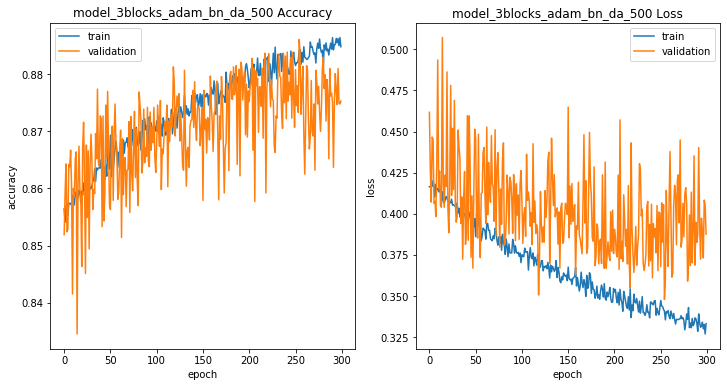

10000/10000 [==============================] - 3s 293us/step
Validation loss: 0.3876521752476692
Validation accuracy: 0.8752999901771545


In [142]:
plot_model(train_history_200_500, "model_3blocks_adam_bn_da_500")
evaluate_model(model_3blocks_adam_bn_da)

Great! It seems to converge at around 400 epochs. And the validation accuracy increase from 81.3% to 87.5% after 400 more epochs training. We will use this one as our final model to run the test set.

## Result

### run the test set

In [140]:
test_scores = model_3blocks_adam_bn_da.evaluate(x_test, y_validation, verbose=1)
print('Test loss:', test_scores[0])
print('Test accuracy:', test_scores[1])

10000/10000 [==============================] - 3s 294us/step
Test loss: 0.39309390032291414
Test accuracy: 0.878000020980835


The test result is 87.8% which is similar to the validation result. It means that our final model generalize well on the whole dataset.

### output the confusion matrix

In [153]:
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

target_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


y_pred = model_3blocks_adam_bn_da.predict(x_test, verbose=2)
y_pred_argmax = y_pred.argmax(axis=1)
y_test_argmax = y_test.argmax(axis=1)
matrix = confusion_matrix(y_test_argmax, y_pred_argmax)

print(classification_report(y_test_argmax, y_pred_argmax, target_names=target_names))


              precision    recall  f1-score   support

    airplane       0.91      0.92      0.91      1000
  automobile       0.95      0.96      0.96      1000
        bird       0.90      0.81      0.86      1000
         cat       0.85      0.66      0.74      1000
        deer       0.89      0.84      0.86      1000
         dog       0.85      0.79      0.82      1000
        frog       0.72      0.97      0.83      1000
       horse       0.90      0.94      0.92      1000
        ship       0.93      0.95      0.94      1000
       truck       0.92      0.95      0.93      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



We can see that the f1-score performance on cat/dog/frog classes are not good. Let's look into the classification details to see how these classes are misclassified.

### output the heatmap
The y axis is the truth, and x axis is the predicted value.

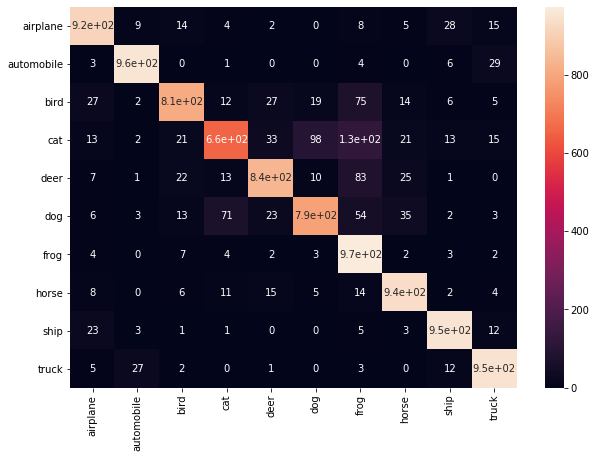

In [156]:
import seaborn as sn
df_cm = pd.DataFrame(matrix, index = target_names,
                  columns = target_names)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

From the heapmap we can see that a lot of image of cat class is classified to frog and dog. Here I list some pairs of classes which get lot of misclassification:
* cat -> frog
* cat -> dog
* dog -> cat
* bird -> frog
* deer -> frog

In the future research, maybe we can add further optimization to help classify dog/cat, and prevent classifying other classes to frog.


### Discussion

At first, we create a base CNN without any regularization and optimization, and it gets 68.37% validation accuracy. Let's summerize how we add different techniques to the base model and improve its performance:

* base: 68.37%
* base + weight decay: didn't improve the validation accuracy
* base + dropout(consistent 0.4): 79.90%
* 3 blocks model + dropout(consistent 0.4): 83.14%
* 3 blocks model + dropout(consistent 0.4) + batch normalization: 85.82%
* 3 blocks model + dropout(consistent 0.4) + batch normalization + data augmentation: 87.53%

And our final model accuracy on test set is: **87.80%**

From the results above, we can learn that to build a good deep learning model, we can try with a simple base structure. Even the performance of the base model doesn't look good at first, we can try adding regularization and optimization techniques to tune the model and get better result!

From my experiments, I can tell dropout is a very good regularization technique, while weight decay doesn't seem to help. And for optimization techniques, I would say adding more blocks(use deeper network) helps, but be mindful to avoid adding too much blocks which cause learning useless features(which can be avoided by using resNet). Batch normalization helps with accelerating the learning process, it also has slightly regularization effect. Data Augmentation makes gradient decent slower to converge, but it does help improve the accuracy as it both expands the training dataset and allows the model to learn the same general features.

